## Setup

In [1]:
# Load packages
using DifferentialEquations
using Plots, StatsPlots
using CSV, DataFrames
using Turing
using LaTeXStrings
using XLSX
using Optim
using StatsBase
using Random
using KernelDensity
using ProgressMeter
using Distributions
using Measures
using GLM
using HypothesisTests

# Setup plots standard
Plots.default(fontfamily = ("computer modern"))

# Set seed 
Random.seed!(42)

TaskLocalRNG()

In [2]:
# Add rhs file
include("model_rhs.jl")
    
# Add parameter file
include("model_default_param.jl")

# Add treatment rhs
include("model_rhs_treatment.jl")

# Add function for calculating VAF
include("model_calc_VAF.jl")

# Add model for Turing inference - individual
include("model_infer_dynamics.jl")

# Add model for Turing inference - hierarchical
include("model_infer_dynamics_Hierarchical_Gibbs_DALIAH.jl")

# Add model for Turing inference - hierarchical - train_test
include("model_infer_dynamics_Hierarchical_Gibbs_DALIAH_train_test.jl")

model_infer_dynamics_Hierarchical_Gibbs_DALIAH_train_test

In [3]:
# Setup initial conditions for master curve
x00 = 1.0*10^5
x10 = 2.5*10^6
x20 = 6.4*10^11
y00 = 1
y10 = 0
y20 = 0
a0 = 8.1*10^2
s0 = 1

# Collect in one vector
u0 = [x00,x10,x20,y00,y10,y20,a0,s0]

# Setup and solve ODEproblem
tspan = (0.0,90*365)
prob = ODEProblem(model_rhs, u0, tspan, p)
sol = solve(prob, TRBDF2(), reltol = 1e-10, abstol = 1e-10, saveat=1)

# Save as named tuple
master_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))

(t = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  32841.0, 32842.0, 32843.0, 32844.0, 32845.0, 32846.0, 32847.0, 32848.0, 32849.0, 32850.0], x0 = [100000.0, 99999.28014604042, 99998.58099317514, 99997.90054517318, 99997.2361247567, 99996.58543544661, 99995.94650693233, 99995.31764842379, 99994.69740877306, 99994.0845423813  …  1.8609987268004509, 1.8600391708260122, 1.859080109644587, 1.8581215430323301, 1.8571634706299531, 1.8562058922481908, 1.855248807523938, 1.8542922162899567, 1.85333611836694, 1.8523805134158782], x1 = [2.5e6, 2.499892552031063e6, 2.4997848422058923e6, 2.4996769420471084e6, 2.4995689453848847e6, 2.4994609323745994e6, 2.4993529714592863e6, 2.4992451210456532e6, 2.4991374309370755e6, 2.499029943558893e6  …  58.85223884536521, 58.82189390263089, 58.791564607190864, 58.761250952072494, 58.73095292584728, 58.700670522809894, 58.67040373102239, 58.640152545142634, 58.609916959557594, 58.57969696360518], x2 = [6.4e11, 6.406571135075917e11, 6.412179399621925e11,

In [4]:
# Setup dataframes
df_D = DataFrame

# Load data
path = "M:/data_cancer/DALIAH/Trine_DALIAH_5y/DALIAH_5y - Export for Julia.csv"
df_D = CSV.read(path, df_D)

# Change data types
df_D[!,:days] = convert.(Float64,df_D[:,:days])
df_D[!,:RUX] = convert.(Float64,df_D[:,:RUX])


df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


In [5]:
# Unique patients
unique_patients = unique(df_D.patientID)

# Number of patients
P = length(unique_patients)

# Convert to starting at time for first data point - no matter if JAK or treatment
for i in unique(df_D.patientID)
    # Set pID
    pID = i
    
    # Extract minimum number of days - where IFN>0 or JAK>=0
    df_p = df_D[df_D.patientID .== pID,:]

    minDays = minimum(df_p.days[df_p.IFN .> 0  .|| df_p.JAK .>= 0, :])
    
    # Subtract minimum number of days
    df_D.days[df_D.patientID .== pID, :] = df_D.days[df_D.patientID .== pID, :] .- minDays
end
df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


In [6]:
# Set seed 
Random.seed!(6)

# Create 80/20 train test split
test_ID = sample(1:P, 14; replace=false)

# Test patients
test_patients = unique_patients[test_ID]
test_patients[test_patients .== 199] .= 200

# Train patients
train_patients = setdiff(unique_patients,test_patients)

sort(test_patients)

14-element Vector{Int64}:
   6
  16
  25
  27
  44
  45
  82
 102
 108
 122
 126
 160
 179
 200

In [7]:
# Create data for training and test data only
df_D_train = copy(df_D)
df_D_test = copy(df_D)

for i=1:length(test_patients)
    tempID = test_patients[i]
    deleteat!(df_D_train, df_D_train.patientID .== tempID)
end

for i=1:length(train_patients)
    tempID = train_patients[i]
    deleteat!(df_D_test, df_D_test.patientID .== tempID)
end

unique(df_D_train.patientID)

56-element Vector{Int64}:
   2
   3
   4
  11
  14
  20
  22
  34
  35
  38
  42
  48
  61
   ⋮
 163
 164
 181
 184
 187
 193
 194
 195
 196
 198
 199
 202

In [8]:
# Create spaghetti plot
fig_spaghetti = plot()
for i=1:length(unique_patients)
    # Select patient
    pID = unique_patients[i]
    
    # Extract data
    df_p = df_D[df_D.patientID .== pID, :]
    
    # Remove NaNs
    df_p = df_p[.!isnan.(df_p.JAK), :]
    
    # Plot
    plot!(df_p.days./30.4, df_p.JAK*100, label="", color = i, linewidth=3)
    scatter!(df_p.days./30.4, df_p.JAK*100, label="", color = i, markersize=4, markerstrokewidth=0.25)
end

# Plot and labels
xlabel!(L"t"*"/months")
ylabel!(L"JAK2"*" VAF/%")
xlims!(0, 75)
ylims!(0, 100)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
plot(fig_spaghetti, size = (700, 500), margin=5mm, leftmargin = 8mm)


# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(fig_spaghetti,figpath*"spaghetti_plot_VAF.png")
savefig(fig_spaghetti,figpath*"spaghetti_plot_VAF.pdf")
savefig(fig_spaghetti,figpath*"spaghetti_plot_VAF.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\spaghetti_plot_VAF.svg"

## Population characteristics

In [8]:
# Extract baseline dataframe
df_B = df_D[df_D.studyVisit .== 0.0, :]

# Extract non-NAN JAK-values
temp_JAK = df_B.JAK[.!isnan.(df_B.JAK)]

# Extract characteristics
[minimum(temp_JAK), median(temp_JAK), mean(temp_JAK), maximum(temp_JAK)]

4-element Vector{Float64}:
 0.001
 0.37
 0.37711428571428574
 0.96

In [9]:
# Extract endpoint dataframe
df_B = df_D[df_D.studyVisit .== 60.0, :]

# Extract non-NAN JAK-values
temp_JAK = df_B.JAK[.!isnan.(df_B.JAK)]

# Extract characteristics
[minimum(temp_JAK), mean(temp_JAK), maximum(temp_JAK)]

3-element Vector{Float64}:
 0.0
 0.0861304347826087
 0.39

## $R$-factor contour plot

In [10]:
# Define artificial patient with constant dose of IFN
df_p = DataFrame(patientID = [-1,-1], days = [0,730], IFN = [45/7,45/7], RUX = [NaN, NaN], JAK = [NaN, NaN], TRC = [NaN, NaN],
                WBC = [NaN, NaN])

# Define days for storing VAF
pDays = 0:30:2*365

# Define initVAF
initJAK = 0.38

# Define effect
effect = "py0dy1"

# Define parameters we want to investigate
rho1_lin = range(0, 1, length=101)
rho2_lin = range(0, 1, length=101)

# Storage
VAF_mat_art = Array{Float64, 3}(undef, length(pDays), length(rho1_lin), length(rho2_lin))
df_R_factor_art = DataFrame(rho1 = Float64[], rho2 = Float64[], R = Float64[])

# Calculate VAF in loop
@showprogress dt=1 desc="Calculating VAF and R-factor for all parameter combinations" for i=1:length(rho1_lin)
    for j=1:length(rho2_lin)
        
        # Set rho values
        rho = [rho1_lin[i], rho2_lin[j]]
        
        # Calculate VAF using function
        VAF_mat_art[:,i,j], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
        
        # Calculate R-factor and append
        R_factor_temp = 100*(1 .- VAF_mat_art[end,i,j]./initJAK)
        df_temp = DataFrame(rho1 = rho[1], rho2 = rho[2], R = R_factor_temp)
        df_R_factor_art = append!(df_R_factor_art, df_temp) 
    end
end

Calculating VAF and R-factor for all parameter combinations 100% Time: 0:00:16


In [13]:
# Contour plot
fig_R_contour = contourf(rho1_lin,rho2_lin,reshape(df_R_factor_art.R,length(rho1_lin),length(rho2_lin)),levels=50,colour=:turbo)
scatter!([1.0, 0.0, 0.16], [0.0, 1.0, 0.16], color = :black, markersize=6, markerstrokewidth=0.25)
title!(L"Contour Plot of $R$-Factor as a Function of $\rho$ and $\delta$")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=15,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, 
        legend = :none, size = (700, 500), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_R_contour,figpath*"R_contour.png")
savefig(fig_R_contour,figpath*"R_contour.pdf")
savefig(fig_R_contour,figpath*"R_contour.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\R_contour.svg"

In [11]:
temp = df_R_factor_art[df_R_factor_art.rho1 .== 0.0, :]
temp = temp[temp.rho2 .== 1.00, :]

Row,rho1,rho2,R
,Float64,Float64,Float64
1,0.0,1.0,56.6544


## Qualitatively different responses

In [12]:
# Define variables for virtual patients 
days1 = 0:365:70*365
days2 = 0:30:2*365
IFN1 = 45/7*ones(size(days1))
IFN2 = 45/7*ones(size(days2))
patientID1 = -1*ones(size(days1))
patientID2 = -1*ones(size(days2))
RUX1 = NaN*ones(size(days1))
RUX2 = NaN*ones(size(days2))
JAK1 = NaN*ones(size(days1))
JAK2 = NaN*ones(size(days2))
TRC1 = NaN*ones(size(days1))
TRC2 = NaN*ones(size(days2))
WBC1 = NaN*ones(size(days1))
WBC2 = NaN*ones(size(days2))

# Define virtual patient with constant dose of IFN
df_p_1 = DataFrame(patientID = patientID1, days = days1, IFN = IFN1, RUX = RUX1, JAK = JAK1, TRC = TRC1, WBC = WBC1)
df_p_2 = DataFrame(patientID = patientID2, days = days2, IFN = IFN2, RUX = RUX2, JAK = JAK2, TRC = TRC2, WBC = WBC2)

# Define rho value
rho_vec = [[0.0,0.0], [0.5,0.0], [0.0,0.5], [0.5,0.5]]
rho_vec = [[0.0,0.0], [1.0,0.0], [0.0,1.0], [1.0,1.0]]

# Choose effect
effect = "py0dy1"

# Create empty plots
fig1 = plot()
fig2 = plot()
fig3 = plot()
fig4 = plot()

# Storage
init1 = zeros(8)
init2 = zeros(8)

# Calculate model output for all virtual patients
@showprogress dt=1 desc="Plotting and saving results for 4 virtual patients..." for i=1:4
    # Choose patient and initJAK
    if i==1
        df_p = df_p_1
        initJAK = 0
    else
        df_p = df_p_2
        initJAK = 0.38
    end
    
    # Extract rho
    rho = rho_vec[i]
    
    # Extract relevant variables
    pDays = df_p.days
    
    # Calculate VAF using function
    VAF_mat, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)

    # Save all variables
    p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
    a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
    
    if i==1
        init1 = [p_curve.x0[1], p_curve.x1[1], p_curve.x2[1], p_curve.y0[1], p_curve.y1[1], p_curve.y2[1], p_curve.a[1],
                 p_curve.s[1]]
    else
        init2 = [p_curve.x0[1], p_curve.x1[1], p_curve.x2[1], p_curve.y0[1], p_curve.y1[1], p_curve.y2[1], p_curve.a[1],
                 p_curve.s[1]]
    end
    
    # Plot 
    figS = plot(p_curve.t/365, p_curve.x0, linewidth = 3,colour=:green1)
    plot!(p_curve.t/365, p_curve.y0, linewidth = 3,colour=:red1)
    plot!(p_curve.t/365, p_curve.x0+p_curve.y0, linewidth = 3,colour=:black,linestyle=:dash)
    title!("Stem Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,2*10^5)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figP = plot(p_curve.t/365, p_curve.x1, linewidth = 3,colour=:green1)
    plot!(p_curve.t/365, p_curve.y1, linewidth = 3,colour=:red1)
    plot!(p_curve.t/365, p_curve.x1+p_curve.y1, linewidth = 3,colour=:black,linestyle=:dash)
    title!("Progenitor and\n Precursor Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,10*10^6)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figM = plot(p_curve.t/365, p_curve.x2, linewidth = 3, label="Healthy cells",colour=:green1)
    plot!(p_curve.t/365, p_curve.y2, linewidth = 3, label="Malignant cells",colour=:red1)
    plot!(p_curve.t/365, p_curve.x2+p_curve.y2, linewidth = 3, label="Sum of healthy\n and malignant cells",colour=:black,linestyle=:dash)
    title!("Mature Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,30*10^11)
    if i==4
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10)
    else
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend=:none)
    end
    figVAF = plot(p_curve.t/365, p_curve.y2./(p_curve.x2+p_curve.y2)*100, linewidth = 3, label = L"JAK2", colour= :darkgoldenrod1)
    title!(L"JAK2"*" VAF")
    xlabel!(L"t"*"/years")
    ylabel!(L"JAK2"*" VAF/%")
    ylims!(0,100)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    
    # Assign to plot
    if i==1
        fig1 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==2
        fig2 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==3
        fig3 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==4
        fig4 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    end
end

# Plot all 4 figures
figCombined = plot(fig1, fig2, fig3, fig4, layout=grid(2,2), size = (1600, 1600))

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figCombined,figpath*"gen_sim_$(effect).png")
savefig(figCombined,figpath*"gen_sim_$(effect).pdf")
savefig(figCombined,figpath*"gen_sim_$(effect).svg")

Plotting and saving results for 4 virtual patients... 100% Time: 0:00:03


"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\gen_sim_py0dy1.svg"

In [13]:
# Define variables for virtual patients 
days = 0:30:2*365
IFN = 45/7*ones(size(days))
patientID = -1*ones(size(days))
RUX = NaN*ones(size(days))
JAK = NaN*ones(size(days))
TRC = NaN*ones(size(days))
WBC = NaN*ones(size(days))

# Define virtual patient with constant dose of IFN
df_p = DataFrame(patientID = patientID, days = days, IFN = IFN, RUX = RUX, JAK = JAK, TRC = TRC, WBC = WBC)

# Choose values of rho and delta
delta_vec = [0.5, 0.25, 0.1, 0.05]
rho_vec = [0.05, 0.1, 0.25, 0.5]

# Choose days for solution
pDays = 0:30:2*365

# Choose effect
effect = "py0dy1"

# Setup for grid plot
grid_plot = Any[]
grid_plot_2 = Any[]

# Counter
counter = 0

# Solve in loop
for i=1:length(delta_vec)
    for j=1:length(rho_vec)
        # Update counter 
        counter = counter + 1

        # Choose values of rho and delta
        rho = [rho_vec[j], delta_vec[i]]

        # Choose initial VAF for simulation
        initJAK= 38/100
        
        # Calculate VAF using function
        VAF, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)

        # Save all variables
        p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
        a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
       #  @show maximum(VAF)
        # Plot
        figVAF = plot([0, 2.5*365]/365, zeros(2), fillrange = [45/7; 45/7], fillalpha = 0.1, 
                        linealpha = 0, line =:steppost, linewidth = 3, label = "", colour= :blue1)
        xlims!(0, 2)
        ylims!(0, 20)
        title!("\n" * L"\rho"
           *"=$(round(rho_vec[j]; sigdigits=3)), " * L"\delta"*"=$(round(delta_vec[i]; sigdigits=3))")
        xlabel!(L"t"*"/years")
        ylabel!(L"IFN-$\alpha$/"*L"\mathrm{\frac{\mu g}{day}}")
        p2 = twinx()
        plot!(p2, p_curve.t/365, VAF*100, linewidth = 6, label = L"JAK2", colour= :darkgoldenrod1)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 2)
        ylims!(p2, 0, 100)
        
        # Plot
        figMatCells = plot([0, 2.5*365]/365, zeros(2), fillrange = [45/7; 45/7], fillalpha = 0.1, 
                        linealpha = 0, line =:steppost, linewidth = 3, label = "", colour= :blue1)
        xlims!(0, 2)
        ylims!(0, 20)
        title!("\n" * L"\rho"
           *"=$(round(rho_vec[j]; sigdigits=3)), " * L"\delta"*"=$(round(delta_vec[i]; sigdigits=3))")
        xlabel!(L"t"*"/years")
        ylabel!(L"IFN-$\alpha$/"*L"\mathrm{\frac{\mu g}{day}}")
        p2 = twinx()
        plot!(p2, p_curve.t/365, p_curve.x2, linewidth = 6, label="",colour=:green1)
        plot!(p2, p_curve.t/365, p_curve.y2, linewidth = 6, label="",colour=:red1)
        plot!(p2, p_curve.t/365, p_curve.x2+p_curve.y2, linewidth = 6, label="",colour=:black,linestyle=:dash)
        ylabel!(p2, "Cells"*L"/1")
        xlims!(p2, 0, 2)
        ylims!(p2, 0, 30*10^11)

        # Add to plot
        push!(grid_plot, figVAF)
        push!(grid_plot_2, figMatCells)
    end
end

In [17]:
# Plot all
figAll = plot(grid_plot..., layout= (4,4), titlefont=20, xtickfontsize=15, ytickfontsize=15, xguidefontsize=15, yguidefontsize=15, 
    legendfontsize=15, legend=:none, size = (2000, 2000), margin=5mm, leftmargin = 8mm, rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figAll,figpath*"vary_response.png")
savefig(figAll,figpath*"vary_response.pdf")
savefig(figAll,figpath*"vary_response.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\vary_response.svg"

In [18]:
# Plot all
figAllCells = plot(grid_plot_2..., layout= (4,4), titlefont=20, xtickfontsize=15, ytickfontsize=15, xguidefontsize=15, yguidefontsize=15, 
    legendfontsize=15, legend=:none, size = (2000, 2000), margin=5mm, leftmargin = 8mm, rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figAllCells,figpath*"vary_response_cells.png")
savefig(figAllCells,figpath*"vary_response_cells.pdf")
savefig(figAllCells,figpath*"vary_response_cells.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\vary_response_cells.svg"

## Hierarchichal inference procedure

In [14]:
# Choose treatment effect
effect = "py0dy1"

# Load MLE results
df_MLE = DataFrame
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y Data - MLE files/MLE_$(effect).csv"
df_MLE = CSV.read(path, df_MLE)

# Remove test patients
for i=1:length(test_patients)
    tempID = test_patients[i]
    deleteat!(df_MLE, df_MLE.patientID .== tempID)
end

# Add new column with sigma
df_MLE.sigma = 1 ./ sqrt.(df_MLE.tau)

# Load standard parameters
include("model_default_param.jl");

# Choose all patients for sampling
VAF = df_D.JAK[.!isnan.(df_D.JAK)]

# Pick out VAF from df_train
VAF_train = df_D_train.JAK[.!isnan.(df_D_train.JAK)]

# Instantiate model
model = model_infer_dynamics_Hierarchical_Gibbs_DALIAH_train_test(VAF_train,df_D_train,effect,p,master_curve)

DynamicPPL.Model{typeof(model_infer_dynamics_Hierarchical_Gibbs_DALIAH_train_test), (:VAF, :df, :effect, :p, :master_curve), (), (), Tuple{Vector{Float64}, DataFrame, String, @NamedTuple{alphax0::Float64, alphay0::Float64, px0::Float64, py0::Float64, alphax1::Float64, alphay1::Float64, px1::Float64, py1::Float64, Ax0::Float64, Ay0::Float64, Ax1::Float64, Ay1::Float64, dx0::Int64, dy0::Int64, dx1::Float64, dy1::Float64, dx2::Float64, dy2::Float64, cxx::Float64, cyx::Float64, cxy::Float64, cyy::Float64, es::Float64, rs::Float64, ea::Float64, I::Int64, sx0::Float64, sy0::Float64, dytilde::Float64, rm::Int64}, @NamedTuple{t::Vector{Float64}, x0::Vector{Float64}, x1::Vector{Float64}, x2::Vector{Float64}, y0::Vector{Float64}, y1::Vector{Float64}, y2::Vector{Float64}, a::Vector{Float64}, s::Vector{Float64}, VAF::Vector{Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(model_infer_dynamics_Hierarchical_Gibbs_DALIAH_train_test, (VAF = [0.49, 0.46, 0.32, 0.21, 0.04, 0.01, 0.006, 0.002, 0.002, 0.54

In [15]:
space = DynamicPPL.syms(DynamicPPL.VarInfo(model))

(:rhobar, :rhotau, :theta_2, :theta_3, :theta_4, :theta_11, :theta_14, :theta_20, :theta_22, :theta_34, :theta_35, :theta_38, :theta_42, :theta_48, :theta_61, :theta_65, :theta_66, :theta_69, :theta_73, :theta_76, :theta_77, :theta_80, :theta_84, :theta_85, :theta_87, :theta_103, :theta_110, :theta_111, :theta_112, :theta_114, :theta_119, :theta_121, :theta_128, :theta_132, :theta_136, :theta_137, :theta_139, :theta_141, :theta_142, :theta_145, :theta_147, :theta_149, :theta_153, :theta_155, :theta_159, :theta_161, :theta_163, :theta_164, :theta_181, :theta_184, :theta_187, :theta_193, :theta_194, :theta_195, :theta_196, :theta_198, :theta_199, :theta_202)

In [16]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

56-element Vector{Int64}:
   2
   3
   4
  11
  14
  20
  22
  34
  35
  38
  42
  48
  61
   ⋮
 163
 164
 181
 184
 187
 193
 194
 195
 196
 198
 199
 202

In [ ]:
# This one is prior on 0 to 1

# Set seed 
Random.seed!(42)

# Sample with Turing
n_samples = 10500

# Model symbols
space = DynamicPPL.syms(DynamicPPL.VarInfo(model))

# Number of parameters
N = length(space)

# Initial parameter values for the sampling - from MLE
init = [mean(df_MLE.rho1), mean(df_MLE.rho2), std(df_MLE.rho1), std(df_MLE.rho2)]

# Tuple of samplers and initial parameters from MLE
A_concrete = ()
for i=1:N
    # Add to sampler list
    if i == findall(==(66),unique_train_patients)[1]
        A_concrete = (A_concrete..., HMC(0.01, 10, space[i]))
    elseif i == findall(==(110),unique_train_patients)[1]
        A_concrete = (A_concrete..., HMC(0.01, 10, space[i]))
    else
        A_concrete = (A_concrete..., HMC(0.05, 10, space[i]))
    end
    
    # Add MLE estimates for patients
    if i>2
        # Add initial parameters from MLE
        temp = collect(df_MLE[i-2, [:rho1, :rho2, :initJAK, :sigma]])
        if temp[1]<0.01
            temp[1] = 0.01
        end
        if temp[2]<0.01
            temp[2] = 0.01
        end
        if temp[3]<0.01
            temp[3] = 0.01
        end
        if temp[4]<0.01
            temp[4] = 0.01
        end
        append!(init, temp)
    end
end

# Setup for sampler
A = typeof(A_concrete)
B_concrete = ntuple(i->1, N)
B = typeof(B_concrete)

# Sampler
sampler = Gibbs{space,N,A,B}(A_concrete,B_concrete)

# Sample
MCMC = sample(model, sampler, n_samples; initial_params=init)

In [ ]:
# Convert to dataframe 
df_MCMC = DataFrame(MCMC)

# Save results
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Hierarchical/MCMC_py0dy1_Hierarchical_Gibbs_long_train_test.csv"
CSV.write(path, df_MCMC)

## Results for individual patients

In [17]:
# Setup dataframes
df_MCMC = DataFrame

# Load data
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y - MCMC files/Hierarchical/MCMC_py0dy1_Hierarchical_Gibbs_long_train_test.csv"
df_MCMC = CSV.read(path, df_MCMC)

Row,iteration,chain,rhobar[1],rhobar[2],rhotau[1],rhotau[2],theta_2[1],theta_2[2],theta_2[3],theta_2[4],theta_3[1],theta_3[2],theta_3[3],theta_3[4],theta_4[1],theta_4[2],theta_4[3],theta_4[4],theta_11[1],theta_11[2],theta_11[3],theta_11[4],theta_14[1],theta_14[2],theta_14[3],theta_14[4],theta_20[1],theta_20[2],theta_20[3],theta_20[4],theta_22[1],theta_22[2],theta_22[3],theta_22[4],theta_34[1],theta_34[2],theta_34[3],theta_34[4],theta_35[1],theta_35[2],theta_35[3],theta_35[4],theta_38[1],theta_38[2],theta_38[3],theta_38[4],theta_42[1],theta_42[2],theta_42[3],theta_42[4],theta_48[1],theta_48[2],theta_48[3],theta_48[4],theta_61[1],theta_61[2],theta_61[3],theta_61[4],theta_65[1],theta_65[2],theta_65[3],theta_65[4],theta_66[1],theta_66[2],theta_66[3],theta_66[4],theta_69[1],theta_69[2],theta_69[3],theta_69[4],theta_73[1],theta_73[2],theta_73[3],theta_73[4],theta_76[1],theta_76[2],theta_76[3],theta_76[4],theta_77[1],theta_77[2],theta_77[3],theta_77[4],theta_80[1],theta_80[2],theta_80[3],theta_80[4],theta_84[1],theta_84[2],theta_84[3],theta_84[4],theta_85[1],theta_85[2],theta_85[3],theta_85[4],theta_87[1],theta_87[2],theta_87[3],theta_87[4],theta_103[1],theta_103[2],⋯
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1,1,0.134823,0.141569,0.393941,0.311371,0.468195,0.419347,0.499577,0.0528847,0.662863,0.489308,0.508142,0.0531422,0.0644958,0.261667,0.328578,0.0325546,0.639898,0.545502,0.107318,0.00546309,0.307918,0.129357,0.547981,0.0460972,0.161955,0.100824,0.422414,0.0486012,0.00639077,0.0384302,0.406746,0.0686181,0.0731753,0.00711631,0.258669,0.0854541,0.527041,0.01,0.624052,0.0159449,0.0782749,0.00564073,0.421798,0.050382,0.01,0.0317346,0.466159,0.01,0.275623,0.388531,0.0127294,0.00855835,0.0482488,0.0196625,0.193944,0.0534394,0.278409,0.195811,0.163636,0.010079,0.0120274,0.15273,0.197822,0.01,0.0935855,0.0117252,0.0185191,0.0104158,0.333338,0.373155,0.855982,0.071186,0.0419259,0.400315,0.382649,0.0115712,0.49698,0.224567,0.0123251,0.0102711,0.574398,0.254603,0.666983,0.107711,0.903485,0.757018,0.770023,0.112071,0.087712,0.0162718,0.160691,0.037174,0.0739503,0.00977797,0.525604,0.141863,0.0427516,0.0159123,⋯
2,2,1,0.11901,0.0966295,0.286364,0.280596,0.468195,0.419347,0.499577,0.0528847,0.58305,0.559168,0.537559,0.0196446,0.0641329,0.189751,0.296524,0.0286169,0.411896,0.560146,0.11992,0.0115014,0.358021,0.169153,0.543886,0.0273176,0.158495,0.12191,0.445543,0.041851,0.00712738,0.0531628,0.434386,0.0650076,0.054992,0.00531796,0.235867,0.0563153,0.653681,0.0110133,0.626637,0.0170468,0.0772237,0.00705311,0.425515,0.049979,0.00458949,0.0417356,0.472772,0.0175915,0.45203,0.268605,0.0093866,0.00670683,0.042163,0.022944,0.207187,0.0562655,0.479926,0.217114,0.16672,0.00622873,0.0120274,0.15273,0.197822,0.01,0.120165,0.0246568,0.0255181,0.0113788,0.227839,0.412325,0.827955,0.0831488,0.0419259,0.400315,0.382649,0.0115712,0.436418,0.290598,0.00997328,0.00645059,0.667799,0.174365,0.623775,0.0696802,0.562252,0.547765,0.658172,0.189803,0.208554,0.00614819,0.160833,0.0214432,0.0788693,0.00872065,0.543964,0.147072,0.0377691,0.0305848,⋯
3,3,1,0.093261,0.0610606,0.259901,0.27448,0.624024,0.367733,0.47746,0.0232708,0.427038,0.516852,0.522914,0.0363962,0.0618149,0.0815526,0.266193,0.0375222,0.347802,0.468142,0.10204

In [18]:
# Remove burn-in
deleteat!(df_MCMC,collect(1:500))

Row,iteration,chain,rhobar[1],rhobar[2],rhotau[1],rhotau[2],theta_2[1],theta_2[2],theta_2[3],theta_2[4],theta_3[1],theta_3[2],theta_3[3],theta_3[4],theta_4[1],theta_4[2],theta_4[3],theta_4[4],theta_11[1],theta_11[2],theta_11[3],theta_11[4],theta_14[1],theta_14[2],theta_14[3],theta_14[4],theta_20[1],theta_20[2],theta_20[3],theta_20[4],theta_22[1],theta_22[2],theta_22[3],theta_22[4],theta_34[1],theta_34[2],theta_34[3],theta_34[4],theta_35[1],theta_35[2],theta_35[3],theta_35[4],theta_38[1],theta_38[2],theta_38[3],theta_38[4],theta_42[1],theta_42[2],theta_42[3],theta_42[4],theta_48[1],theta_48[2],theta_48[3],theta_48[4],theta_61[1],theta_61[2],theta_61[3],theta_61[4],theta_65[1],theta_65[2],theta_65[3],theta_65[4],theta_66[1],theta_66[2],theta_66[3],theta_66[4],theta_69[1],theta_69[2],theta_69[3],theta_69[4],theta_73[1],theta_73[2],theta_73[3],theta_73[4],theta_76[1],theta_76[2],theta_76[3],theta_76[4],theta_77[1],theta_77[2],theta_77[3],theta_77[4],theta_80[1],theta_80[2],theta_80[3],theta_80[4],theta_84[1],theta_84[2],theta_84[3],theta_84[4],theta_85[1],theta_85[2],theta_85[3],theta_85[4],theta_87[1],theta_87[2],theta_87[3],theta_87[4],theta_103[1],theta_103[2],⋯
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,501,1,0.125283,0.0297482,0.211217,0.297,0.588101,0.479659,0.498924,0.0200276,0.398396,0.61703,0.576145,0.0283817,0.0803409,0.231941,0.354705,0.0560671,0.333084,0.47057,0.0957624,0.00883006,0.221564,0.293312,0.576266,0.0547118,0.125657,0.187342,0.486918,0.0730252,0.00597108,0.116366,0.480969,0.0506212,0.193348,0.415151,0.297809,0.197599,0.0106399,0.209471,0.432087,0.242594,0.533261,0.14007,0.206385,0.255723,0.16069,0.168595,0.523585,0.0645261,0.188215,0.222073,0.00578409,0.00273339,0.0715182,0.0092829,0.208378,0.0644254,0.144585,0.191716,0.15491,0.0307301,0.321261,0.0465854,0.159816,0.0460132,0.469942,0.500905,0.0373953,0.0145572,0.244486,0.842075,0.896713,0.155326,0.0549633,0.420544,0.398252,0.0167097,0.428044,0.375286,0.0058085,0.00926468,0.500193,0.197144,0.770515,0.145996,0.335601,0.365384,0.417891,0.230719,0.0994102,0.199557,0.210565,0.205936,0.172124,0.0501915,0.930084,0.42294,0.0431377,0.104993,⋯
2,502,1,0.148189,0.074685,0.191235,0.265561,0.491781,0.338167,0.445755,0.0252658,0.251373,0.532405,0.531064,0.0750985,0.0636309,0.244592,0.286918,0.0448108,0.333084,0.47057,0.0957624,0.00883006,0.343894,0.329409,0.632988,0.0492688,0.178379,0.21671,0.480515,0.0775353,0.00423484,0.0677693,0.42407,0.058688,0.0976259,0.369214,0.489555,0.230335,0.0123353,0.371348,0.716282,0.213871,0.270115,0.252932,0.319137,0.244542,0.279882,0.07665,0.478361,0.110331,0.241906,0.249976,0.00374606,0.00148175,0.0829525,0.00908052,0.217603,0.072582,0.119296,0.130886,0.170827,0.0227896,0.294328,0.0644507,0.111044,0.101977,0.436128,0.561054,0.0332477,0.0390116,0.376362,0.366603,0.909059,0.166949,0.0280929,0.346818,0.342493,0.0217062,0.462486,0.484201,0.00869652,0.0038533,0.508987,0.228988,0.711019,0.064719,0.41562,0.409333,0.433342,0.275993,0.127819,0.244465,0.212129,0.181946,0.191319,0.0507495,0.935848,0.4144,0.0572204,0.139622,⋯
3,503,1,0.138843,0.0673809,0.189945,0.281703,0.50178,0.593915,0.558258,0.0270135,0.611539,0.509282,0.480487,0.0632475,0.0656796,0.318556,0.321271,0.0354285,0.340768,0.725036,0.106891,0.0

In [24]:
# Plot poluation chains

# Plot density
l = @layout [a a; a a; a a; a a;]
plot_rho1bar_chain = plot(df_MCMC[:,"iteration"],df_MCMC[:,"rhobar[1]"],linewidth = 0.5, colour = 1, label = "")
title!("\nChain for "*L"\mu_\rho")
xlabel!("Iteration")
ylabel!(L"\mu_\rho/\textrm{(\mu g/day)}^{-1}")
plot_rho1bar_density = plot(density(df_MCMC[:,"rhobar[1]"],legend=false),linewidth = 0.5, colour = 1, label = "")
# xlims!(0, 3)
title!("\nDensity for "*L"\mu_\rho")
xlabel!(L"\mu_\rho/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
plot_rho1sd_chain = plot(df_MCMC[:,"iteration"], df_MCMC[:,"rhotau[1]"],linewidth = 0.5, colour = 1, label = "")
title!("Chain for "*L"\sigma_\rho")
xlabel!("Iteration")
ylabel!(L"\sigma_\rho/\textrm{(\mu g/day)}^{-1}")
# ylims!(0,5)
plot_rho1sd_density = plot(density(df_MCMC[:,"rhotau[1]"],legend=false),linewidth = 0.5, colour = 1, label = "")
# xlims!(0, 0.2)
title!("Density for "*L"\sigma_\rho")
xlabel!(L"\sigma_\rho/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
plot_rho2bar_chain = plot(df_MCMC[:,"iteration"],df_MCMC[:,"rhobar[2]"],linewidth = 0.5, colour = 1, label = "")
title!("\nChain for "*L"\mu_\delta")
xlabel!("Iteration")
ylabel!(L"\mu_\delta/\textrm{(\mu g/day)}^{-1}")
plot_rho2bar_density = plot(density(df_MCMC[:,"rhobar[2]"],legend=false),linewidth = 0.5, colour = 1, label = "")
# xlims!(0, 0.2)
title!("\nDensity for "*L"\mu_\delta")
xlabel!(L"\mu_\delta/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
plot_rho2sd_chain = plot(df_MCMC[:,"iteration"], df_MCMC[:,"rhotau[2]"],linewidth = 0.5, colour = 1, label = "")
title!("Chain for "*L"\sigma_\delta")
xlabel!("Iteration")
ylabel!(L"\sigma_\delta/\textrm{(\mu g/day)}^{-1}")
plot_rho2sd_density = plot(density(df_MCMC[:,"rhotau[2]"],legend=false),linewidth = 0.5, colour = 1, label = "")
# xlims!(0, 0.2)
title!("Density for "*L"\sigma_\delta")
xlabel!(L"\sigma_\delta/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
figcombined = plot(plot_rho1bar_chain,plot_rho1bar_density,plot_rho1sd_chain,plot_rho1sd_density,plot_rho2bar_chain,
    plot_rho2bar_density,plot_rho2sd_chain,plot_rho2sd_density,layout = l,size = (700, 1000), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figcombined,figpath*"Popluation_MCMC_$(effect).png")
savefig(figcombined,figpath*"Popluation_MCMC_$(effect).pdf")
savefig(figcombined,figpath*"Popluation_MCMC_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Popluation_MCMC_py0dy1.svg"

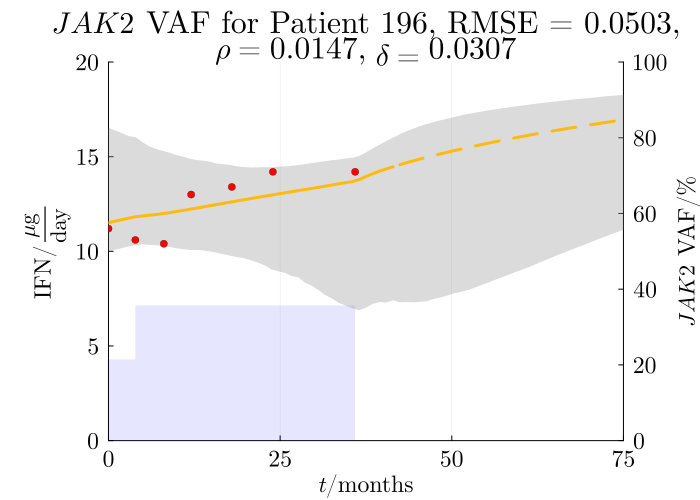

In [44]:
# Extract relevant data
pID = 196
df_p = df_D_train[df_D_train.patientID .== pID, :]

# Create copy of df_p with constant dose - 45/7
df_p_const = copy(df_p)
df_p_const.IFN[df_p_const.days.>=0] .= 45/7

# Extract latest data point
maxDays = maximum(df_p.days)

# Extract VAF
pVAF = df_p.JAK

# Choose treatment effect
effect = "py0dy1"

# Choose time for calculating VAF
pDays = 0:30:75*30.4
pDays2 = df_p.days[.!isnan.(df_p.JAK)]
pDays_const = [0,2*365]

# Load standard parameters
include("model_default_param.jl");

# Storage
VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
VAF_mat_const = Array{Float64, 2}(undef, length(pDays_const), length(df_MCMC[:,"iteration"]))
p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

# Calculate VAF in loop
for j in eachindex(df_MCMC[:,"iteration"])
    # Set rho values
    rho = [df_MCMC[j,"theta_$(pID)[1]"], df_MCMC[j,"theta_$(pID)[2]"]]

    # Set initial JAK
    initJAK = df_MCMC[j,"theta_$(pID)[3]"]

    # Calculate VAF using function
    VAF_mat[:,j], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
    VAF_mat_points[:,j], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
    VAF_mat_const[:,j], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)

    # Save all variables
    p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
    a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
    p_mat[:,j,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
end

# Calculate RMSE based on mean at the points
RMSE = rmsd(median(VAF_mat_points, dims=2),df_p.JAK[.!isnan.(df_p.JAK)])

# Calculate mean width of 95% CI
mean_width = mean(abs.(quantile.(eachrow(VAF_mat), 0.975)*100-quantile.(eachrow(VAF_mat), 0.025)*100))

# Calculate mean and median parameter values
mean_param_1 = mean(df_MCMC[:,"theta_$(pID)[1]"])
mean_param_2 = mean(df_MCMC[:,"theta_$(pID)[2]"])
median_param_1 = median(df_MCMC[:,"theta_$(pID)[1]"])
median_param_2 = median(df_MCMC[:,"theta_$(pID)[2]"])

# Plot results
figVAF = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
        linewidth = 3, label = "", colour= :blue1)
plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
      linewidth = 3, label = "", colour= :blue1)
title!(L"JAK2"*" VAF for Patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho="
       *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
xlabel!(L"t"*"/months")
ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
xlims!(0, 75)
ylims!(0, 20)
p2 = twinx()
plot!(p2, pDays/30.4, quantile.(eachrow(VAF_mat), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat), 0.975)*100, fillalpha = 0.35, 
     colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
# plot!(p2, pDays[pDays.<=maxDays]/30.4, mean(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
#          label = L"JAK2"*" VAF - Mean", colour= :darkgoldenrod1)
# plot!(p2, pDays[pDays.>maxDays]/30.4, mean(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
#       label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
plot!(p2, pDays[pDays.<=maxDays]/30.4, median(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
      label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
plot!(p2, pDays[pDays.>maxDays]/30.4, median(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
      label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
scatter!(p2, df_p.days./30.4, df_p.JAK*100, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
ylabel!(p2, L"JAK2"*" VAF/%")
xlims!(p2, 0, 75)
ylims!(p2, 0, 100)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
plot(figVAF, size = (700, 500), margin=5mm, leftmargin = 8mm)

In [45]:
mean_width

35.760952430518394

In [26]:
# Plot 4 patient plots in one figure

# Choose patients
p_vec = [3,76,110,196]

# Create empty plots
fig1 = plot()
fig2 = plot()
fig3 = plot()
fig4 = plot()

@showprogress dt=1 desc="Plotting and saving results for all patients..." for i=1:4
    # Extract relevant data
    pID = p_vec[i]
    df_p = df_D_train[df_D_train.patientID .== pID, :]

    # Create copy of df_p with constant dose - 45/7
    df_p_const = copy(df_p)
    df_p_const.IFN[df_p_const.days.>=0] .= 45/7

    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK

    # Choose treatment effect
    effect = "py0dy1"

    # Choose time for calculating VAF
    pDays = 0:30:75*30.4
    pDays2 = df_p.days[.!isnan.(df_p.JAK)]
    pDays_const = [0,2*365]

    # Load standard parameters
    include("model_default_param.jl");

    # Storage
    VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
    VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
    VAF_mat_const = Array{Float64, 2}(undef, length(pDays_const), length(df_MCMC[:,"iteration"]))
    p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

    # Calculate VAF in loop
    for j in eachindex(df_MCMC[:,"iteration"])
        # Set rho values
        rho = [df_MCMC[j,"theta_$(pID)[1]"], df_MCMC[j,"theta_$(pID)[2]"]]

        # Set initial JAK
        initJAK = df_MCMC[j,"theta_$(pID)[3]"]

        # Calculate VAF using function
        VAF_mat[:,j], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
        VAF_mat_points[:,j], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
        VAF_mat_const[:,j], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)

        # Save all variables
        p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
        a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
        p_mat[:,j,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
    end

    # Calculate RMSE based on mean at the points
    RMSE = rmsd(median(VAF_mat_points, dims=2),df_p.JAK[.!isnan.(df_p.JAK)])

    # Calculate mean width of 95% CI
    mean_width = mean(abs.(quantile.(eachrow(VAF_mat), 0.975)*100-quantile.(eachrow(VAF_mat), 0.025)*100))

    # Calculate mean and median parameter values
    mean_param_1 = mean(df_MCMC[:,"theta_$(pID)[1]"])
    mean_param_2 = mean(df_MCMC[:,"theta_$(pID)[2]"])
    median_param_1 = median(df_MCMC[:,"theta_$(pID)[1]"])
    median_param_2 = median(df_MCMC[:,"theta_$(pID)[2]"])

   # Plot results
    figVAF = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
            linewidth = 3, label = "", colour= :blue1)
    plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
          linewidth = 3, label = "", colour= :blue1)
    title!(L"JAK2"*" VAF for Patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho="
           *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
    xlims!(0, 75)
    ylims!(0, 20)
    p2 = twinx()
    plot!(p2, pDays/30.4, quantile.(eachrow(VAF_mat), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat), 0.975)*100, fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
#     plot!(p2, pDays[pDays.<=maxDays]/30.4, mean(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
#              label = L"JAK2"*" VAF - Mean", colour= :darkgoldenrod1)
#     plot!(p2, pDays[pDays.>maxDays]/30.4, mean(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
#           label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
    plot!(p2, pDays[pDays.<=maxDays]/30.4, median(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 6, 
          label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
    plot!(p2, pDays[pDays.>maxDays]/30.4, median(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 6, 
          label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
    scatter!(p2, df_p.days./30.4, df_p.JAK*100, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
    ylabel!(p2, L"JAK2"*" VAF/%")
    xlims!(p2, 0, 75)
    ylims!(p2, 0, 100)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    
    if i==1
        fig1 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==2
        fig2 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==3
        fig3 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==4
        fig4 = plot(figVAF, size = (700, 500), margin=5mm)
    end
end

# Plot all 4 figures
figCombined = plot(fig1, fig2, fig3, fig4, layout=grid(2,2), size = (1500, 1000), margin = 5mm, leftmargin = 8mm, 
                   rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figCombined,figpath*"Representative_patients_VAF_$(effect).png")
savefig(figCombined,figpath*"Representative_patients_VAF_$(effect).pdf")
savefig(figCombined,figpath*"Representative_patients_VAF_$(effect).svg")

Plotting and saving results for all patients... 100%|████| Time: 0:11:30


"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Representative_patients_VAF_py0dy1.svg"

In [27]:
# Plot 4 patient plots in one figure - cells

# Choose patients
p_vec = [3,76,110,196]

# Create empty plots
fig1 = plot()
fig2 = plot()
fig3 = plot()
fig4 = plot()

@showprogress dt=1 desc="Plotting and saving results for all patients..." for i=1:4
    # Extract relevant data
    pID = p_vec[i]
    df_p = df_D_train[df_D_train.patientID .== pID, :]

    # Create copy of df_p with constant dose - 45/7
    df_p_const = copy(df_p)
    df_p_const.IFN[df_p_const.days.>=0] .= 45/7

    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK

    # Choose treatment effect
    effect = "py0dy1"

    # Choose time for calculating VAF
    pDays = 0:1:7*365
    pDays2 = df_p.days[.!isnan.(df_p.JAK)]
    pDays_const = [0,2*365]

    # Load standard parameters
    include("model_default_param.jl");

    # Storage
    VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
    VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
    VAF_mat_const = Array{Float64, 2}(undef, length(pDays_const), length(df_MCMC[:,"iteration"]))
    p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

    # Calculate VAF in loop
    for j in eachindex(df_MCMC[:,"iteration"])
        # Set rho values
        rho = [df_MCMC[j,"theta_$(pID)[1]"], df_MCMC[j,"theta_$(pID)[2]"]]

        # Set initial JAK
        initJAK = df_MCMC[j,"theta_$(pID)[3]"]

        # Calculate VAF using function
        VAF_mat[:,j], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
        VAF_mat_points[:,j], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
        VAF_mat_const[:,j], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)

        # Save all variables
        p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
        a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
        p_mat[:,j,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
    end

    # Extract data points that are non-NAN and for time greater than 0
    pWBC = df_p.WBC[.!isnan.(df_p.WBC)]
    WBC_days = df_p.days[.!isnan.(df_p.WBC)]
    pWBC = pWBC[WBC_days.>=0]
    WBC_days = WBC_days[WBC_days.>=0]

    # Storage
    pWBC_model = Array{Float64, 1}(undef, length(WBC_days))

    # Extract values in loop
    for k=1:length(WBC_days)
        ID = findfirst(days -> days == WBC_days[k], pDays)
        pWBC_model[k] = mean(p_mat[ID,:,3]+p_mat[ID,:,6])
    end

    # Setup dataframe
    data_WBC = DataFrame(x = pWBC_model, y=pWBC*10^9)

    # Setup model and calculate optimal fit
    model_WBC = lm(@formula(y ~ 0 + x), data_WBC)

    # Extract fit coefficient
    kWBC = coef(model_WBC)[1]
    
    # Calculate RMSE based on mean at the points
    RMSE_WBC = rmsd(kWBC*pWBC_model,pWBC*10^9)
    
    # Calculate CV
    CV_WBC = std(kWBC*pWBC_model-pWBC*10^9)/mean(kWBC*pWBC_model-pWBC*10^9)

    # Setup prediction interval
    data_WBC_new = DataFrame(x = pWBC_model)

    # Calculate prediction interval
    co_WBC = predict(model_WBC, data_WBC_new, interval = :confidence, level = 0.95)
    pr_WBC = predict(model_WBC, data_WBC_new, interval = :prediction, level = 0.95)

    # Convert to Float64
    co_WBC[!,:] = convert.(Float64,co_WBC)
    pr_WBC[!,:] = convert.(Float64,pr_WBC)
    
    # Extract data points that are non-NAN and for time greater than 0
    pTRC = df_p.TRC[.!isnan.(df_p.TRC)]
    TRC_days = df_p.days[.!isnan.(df_p.TRC)]
    pTRC = pTRC[TRC_days.>=0]
    TRC_days = TRC_days[TRC_days.>=0]

    # Storage
    pTRC_model = Array{Float64, 1}(undef, length(TRC_days))

    # Extract values in loop
    for k=1:length(TRC_days)
        ID = findfirst(days -> days == TRC_days[k], pDays)
        pTRC_model[k] = mean(p_mat[ID,:,3]+p_mat[ID,:,6])
    end

    # Setup dataframe
    data_TRC = DataFrame(x = pTRC_model, y=pTRC*10^9)

    # Setup model and calculate optimal fit
    model_TRC = lm(@formula(y ~ 0 + x), data_TRC)

    # Extract fit coefficient
    kTRC = coef(model_TRC)[1]
    
    # Calculate RMSE based on mean at the points
    RMSE_TRC = rmsd(kTRC*pTRC_model,pTRC*10^9)
    
    # Calculate CV for errors
    CV_TRC = std(kWBC*pWBC_model-pWBC*10^9)/mean(kWBC*pWBC_model-pWBC*10^9)

    # Setup prediction interval
    data_TRC_new = DataFrame(x = pTRC_model)

    # Calculate prediction interval
    co_TRC = predict(model_TRC, data_TRC_new, interval = :confidence, level = 0.95)
    pr_TRC = predict(model_TRC, data_TRC_new, interval = :prediction, level = 0.95)

    # Convert to Float64
    co_TRC[!,:] = convert.(Float64,co_TRC)
    pr_TRC[!,:] = convert.(Float64,pr_TRC)

    # Plot results
    # Plot WBC
    figWBC = plot(pDays[pDays.<=maxDays]/30.4, kWBC*mean(p_mat[pDays.<=maxDays,:,3]+p_mat[pDays.<=maxDays,:,6],dims=2), linewidth = 3, label = "",
         colour= :black)
    plot!(pDays[pDays.>maxDays]/30.4, kWBC*mean(p_mat[pDays.>maxDays,:,3]+p_mat[pDays.>maxDays,:,6],dims=2), linewidth = 3, label = "",
         colour= :black, linestyle = :dash)
    plot!(WBC_days/30.4, co_WBC.lower, fillrange = co_WBC.upper, fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Prediction\ Interval}", linealpha = 0)
    plot!([0,75],[3.5*10^9,3.5*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    plot!([0,75],[8.8*10^9,8.8*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    scatter!(df_p.days./30.4, df_p.WBC*10^9, label=L"\textrm{Data}", markercolor=:red, markersize=6, markerstrokewidth=0.25)
    title!("Leukocytes for patient $(pID),\n" * "RMSE = $(round(RMSE_WBC; sigdigits=3)), "*L"k_\textrm{L}="
           *"$(round(kWBC; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("Cells/L")
    xlims!(-Inf, 75)
    ylims!(0,30*10^9)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
    # Plot TRC
    figTRC = plot(pDays[pDays.<=maxDays]/30.4, kTRC*mean(p_mat[pDays.<=maxDays,:,3]+p_mat[pDays.<=maxDays,:,6],dims=2), linewidth = 3, label = "",
     colour= :black)
    plot!(pDays[pDays.>maxDays]/30.4, kTRC*mean(p_mat[pDays.>maxDays,:,3]+p_mat[pDays.>maxDays,:,6],dims=2), linewidth = 3, label = "",
         colour= :black, linestyle = :dash)
    plot!(TRC_days/30.4, co_TRC.lower, fillrange = co_TRC.upper, fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Prediction\ Interval}", linealpha = 0)
    plot!([0,75],[145*10^9,145*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    plot!([0,75],[390*10^9,390*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    scatter!(df_p.days./30.4, df_p.TRC*10^9, label=L"\textrm{Data}", markercolor=:red, markersize=6, markerstrokewidth=0.25)
    title!("Thrombocytes for patient $(pID),\n" * "RMSE = $(round(RMSE_TRC; sigdigits=3)), "*L"k_\textrm{T}="
           *"$(round(kTRC; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("Cells/L")
    xlims!(-Inf, 75)
    ylims!(0,11*10^11)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
    l = @layout [a; a;]
    if i==1
        fig1 = plot(figWBC, figTRC, size = (700, 1000), margin=5mm)
    elseif i==2
        fig2 = plot(figWBC, figTRC, size = (700, 1000), margin=5mm)
    elseif i==3
        fig3 = plot(figWBC, figTRC, size = (700, 1000), margin=5mm)
    elseif i==4
        fig4 = plot(figWBC, figTRC, size = (700, 1000), margin=5mm)
    end
end

# Plot all 4 figures
# figCombined = plot(fig1, fig2, fig3, fig4, layout=grid(2,2), size = (2500, 1500), margin = 10mm)
figCombined = plot(fig1, size = (2500,1500), margin = 10mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figCombined,figpath*"Representative_patients_Cells_$(effect).png")
savefig(figCombined,figpath*"Representative_patients_Cells_$(effect).pdf")
savefig(figCombined,figpath*"Representative_patients_Cells_$(effect).svg")

Plotting and saving results for all patients... 100%|████| Time: 0:14:01


"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Representative_patients_Cells_py0dy1.svg"

In [19]:
# Define doses we want to investigate we want to investigate
cI_lin = range(0,180,51)./7
cI_lin = range(0,180,2)./7

# Number of patients
P_train = length(unique_train_patients)

# Storage
real_VAF = Float64[]
predicted_VAF = Float64[]
R_factor = fill(NaN, P_train, length(df_MCMC[:,"iteration"]))
R_factor_mat = zeros(length(cI_lin),length(df_MCMC[:,"iteration"]))
mean_RMSE_vec = Array{Float64, 1}(undef, P_train)
mean_RMSE_WBC_vec = Array{Float64, 1}(undef, P_train)
mean_RMSE_TRC_vec = Array{Float64, 1}(undef, P_train)
mean_Rhat_vec = Array{Float64, 1}(undef, P_train)
n_data_vec = Array{Float64, 1}(undef, P_train) 
mean_rho_py0_vec = Array{Float64, 1}(undef, P_train)
mean_rho_dy1_vec = Array{Float64, 1}(undef, P_train)
median_rho_py0_vec = Array{Float64, 1}(undef, P_train)
median_rho_dy1_vec = Array{Float64, 1}(undef, P_train)
k_WBC_vec = Array{Float64, 1}(undef, P_train)
k_TRC_vec = Array{Float64, 1}(undef, P_train)

# Setup for stamp plots
stamp_plot_1 = Any[]
stamp_plot_2 = Any[]
stamp_plot_3 = Any[]
stamp_plot_4 = Any[]


# Plot for all patients in loop
@showprogress dt=1 desc="Plotting and saving results for all patients..." for i=1:P_train
# @showprogress dt=1 desc="Plotting and saving results for all patients..." for i=1:2
    # Extract relevant data
    pID = unique_train_patients[i]
    df_p = df_D_train[df_D_train.patientID .== pID, :]
    
    # Create copy of df_p with constant dose - 45/7
    df_p_const = copy(df_p)
    df_p_const.IFN[df_p_const.days.>=0] .= 45/7
    
    # Extract latest data point
    maxDays = maximum(df_p.days)

    # Extract VAF
    pVAF = df_p.JAK

    # Choose treatment effect
    effect = "py0dy1"

    # Choose time for calculating VAF
    pDays = 0:1:7*365
    pDays2 = df_p.days[.!isnan.(df_p.JAK)]
    pDays_const = [0,2*365]
    pDays_plot = pDays[1:30:end]

    # Load standard parameters
    include("model_default_param.jl");

    # Storage
    VAF_mat = Array{Float64, 2}(undef, length(pDays), length(df_MCMC[:,"iteration"]))
    VAF_mat_points = Array{Float64, 2}(undef, length(pDays2), length(df_MCMC[:,"iteration"]))
    VAF_mat_const = Array{Float64, 2}(undef, length(pDays_const), length(df_MCMC[:,"iteration"]))
    p_mat = Array{Float64, 3}(undef, length(pDays), length(df_MCMC[:,"iteration"]), 8)

    # Calculate VAF in loop
    for j in eachindex(df_MCMC[:,"iteration"])
        # Set rho values
        rho = [df_MCMC[j,"theta_$(pID)[1]"], df_MCMC[j,"theta_$(pID)[2]"]]

        # Set initial JAK
        initJAK = df_MCMC[j,"theta_$(pID)[3]"]

        # Calculate VAF using function
        VAF_mat[:,j], sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
        VAF_mat_points[:,j], sol_points = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)
        VAF_mat_const[:,j], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)
        
        # Save all variables
        p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
        a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
        p_mat[:,j,:] = [p_curve.x0 p_curve.x1 p_curve.x2 p_curve.y0 p_curve.y1 p_curve.y2 p_curve.a p_curve.s]
        
    end
    VAF_mat_plot = VAF_mat[1:30:end,:]
    
    # Calculate RMSE based on mean at the points
    RMSE = rmsd(median(VAF_mat_points, dims=2),df_p.JAK[.!isnan.(df_p.JAK)])
    
    # Save mean RMSE
    mean_RMSE_vec[i] = RMSE
    
    # Calculate Rhat based on mean at the points
    sumE = sum((median(VAF_mat_points, dims=2).-df_p.JAK[.!isnan.(df_p.JAK)]).^2)
    sumJ = sum((df_p.JAK[.!isnan.(df_p.JAK)].-mean(df_p.JAK[.!isnan.(df_p.JAK)])).^2)
    n_data_vec[i] = length(df_p.JAK[.!isnan.(df_p.JAK)])
    n_param = 3
    mean_Rhat_vec[i] = 1-sumE/sumJ*(n_data_vec[i]-1)/(n_data_vec[i]-n_param-1)
        
    # Save real and predicted VAF
    append!(real_VAF, df_p.JAK[.!isnan.(df_p.JAK)])
    append!(predicted_VAF, median(VAF_mat_points, dims=2))
    
    # Calculate mean and median parameter values
    mean_param_1 = mean(df_MCMC[:,"theta_$(pID)[1]"])
    mean_param_2 = mean(df_MCMC[:,"theta_$(pID)[2]"])
    median_param_1 = median(df_MCMC[:,"theta_$(pID)[1]"])
    median_param_2 = median(df_MCMC[:,"theta_$(pID)[2]"])
    
    # Save mean and median parameter values
    mean_rho_py0_vec[i] = mean_param_1
    mean_rho_dy1_vec[i] = mean_param_2
    median_rho_py0_vec[i] = median_param_1
    median_rho_dy1_vec[i] = median_param_2

    # Calculate R factor
    R_factor[i,:] = 100*(1 .- VAF_mat_const[2,:]./VAF_mat_const[1,:])
    
    # Extract data points that are non-NAN and for time greater than 0
    pWBC = df_p.WBC[.!isnan.(df_p.WBC)]
    WBC_days = df_p.days[.!isnan.(df_p.WBC)]
    pWBC = pWBC[WBC_days.>=0]
    WBC_days = WBC_days[WBC_days.>=0]

    # Storage
    pWBC_model = Array{Float64, 1}(undef, length(WBC_days))

    # Extract values in loop
    for k=1:length(WBC_days)
        ID = findfirst(days -> days == WBC_days[k], pDays)
        pWBC_model[k] = mean(p_mat[ID,:,3]+p_mat[ID,:,6])/(30.5*5)
    end
    

    # Setup dataframe
    data_WBC = DataFrame(x = pWBC_model, y=pWBC*10^9)

    # Setup model and calculate optimal fit
    model_WBC = lm(@formula(y ~ 0 + x), data_WBC)

    # Extract fit coefficient
    kWBC = coef(model_WBC)[1]
    
    # Calculate RMSE based on mean at the points
    RMSE_WBC = rmsd(kWBC*pWBC_model,pWBC*10^9)/((3.5*10^9+8.8*10^9)/2)
    
    # Save values
    k_WBC_vec[i] = kWBC
    mean_RMSE_WBC_vec[i] = RMSE_WBC

    # Setup prediction interval
    data_WBC_new = DataFrame(x = pWBC_model)

    # Calculate prediction interval
    co_WBC = predict(model_WBC, data_WBC_new, interval = :confidence, level = 0.95)
    pr_WBC = predict(model_WBC, data_WBC_new, interval = :prediction, level = 0.95)

    # Convert to Float64
    co_WBC[!,:] = convert.(Float64,co_WBC)
    pr_WBC[!,:] = convert.(Float64,pr_WBC)
    
    # Extract data points that are non-NAN and for time greater than 0
    pTRC = df_p.TRC[.!isnan.(df_p.TRC)]
    TRC_days = df_p.days[.!isnan.(df_p.TRC)]
    pTRC = pTRC[TRC_days.>=0]
    TRC_days = TRC_days[TRC_days.>=0]

    # Storage
    pTRC_model = Array{Float64, 1}(undef, length(TRC_days))

    # Extract values in loop
    for k=1:length(TRC_days)
        ID = findfirst(days -> days == TRC_days[k], pDays)
        pTRC_model[k] = mean(p_mat[ID,:,3]+p_mat[ID,:,6])/(30.5*5)
    end

    # Setup dataframe
    data_TRC = DataFrame(x = pTRC_model, y=pTRC*10^9)

    # Setup model and calculate optimal fit
    model_TRC = lm(@formula(y ~ 0 + x), data_TRC)

    # Extract fit coefficient
    kTRC = coef(model_TRC)[1]
    
    # Calculate RMSE based on mean at the points
    RMSE_TRC = rmsd(kTRC*pTRC_model,pTRC*10^9)/((145*10^9+390*10^9)/2)
    
    # Save values
    k_TRC_vec[i] = kTRC
    mean_RMSE_TRC_vec[i] = RMSE_TRC

    # Setup prediction interval
    data_TRC_new = DataFrame(x = pTRC_model)

    # Calculate prediction interval
    co_TRC = predict(model_TRC, data_TRC_new, interval = :confidence, level = 0.95)
    pr_TRC = predict(model_TRC, data_TRC_new, interval = :prediction, level = 0.95)

    # Convert to Float64
    co_TRC[!,:] = convert.(Float64,co_TRC)
    pr_TRC[!,:] = convert.(Float64,pr_TRC)
    
    for i=1:length(cI_lin)
        # Create copy of df_p with constant dose 
        df_p_const = copy(df_p)
        df_p_const.IFN[df_p_const.days.>=0] .= cI_lin[i]


        # Extract VAF
        pVAF = df_p.JAK

        # Choose treatment effect
        effect = "py0dy1"

        # Choose time for calculating VAF
        pDays_const = [0,2*365]

        # Load standard parameters
        include("model_default_param.jl")

        # Storage
        VAF_mat_const = Array{Float64, 2}(undef, length(pDays_const), length(df_MCMC[:,"iteration"]))

        # Calculate VAF in loop
        for j in eachindex(df_MCMC[:,"iteration"])
            # Set rho values
            rho = [df_MCMC[j,"theta_$(pID)[1]"], df_MCMC[j,"theta_$(pID)[2]"]]

            # Set initial JAK
            initJAK = df_MCMC[j,"theta_$(pID)[3]"]

            # Calculate VAF using function
            VAF_mat_const[:,j], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)
        end

        # Calculate R-factor and append
        R_factor_mat[i,:] = 100*(1 .- VAF_mat_const[end,:]./df_MCMC[:,"theta_$(pID)[3]"])
    end

    # Plot results
    figVAF = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
            linewidth = 3, label = "", colour= :blue1)
    plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
          linewidth = 3, label = "", colour= :blue1)
    title!(L"JAK2"*" VAF for patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho="
           *"$(round(median_param_1; sigdigits=3)), " * L"\delta="*"$(round(median_param_2; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
    xlims!(0, 75)
    ylims!(0, 20)
    p2 = twinx()
    plot!(p2, pDays_plot/30.4, quantile.(eachrow(VAF_mat_plot), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat_plot), 0.975)*100,
          fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
#     plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, mean(VAF_mat_plot[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 3, 
#              label = L"JAK2"*" VAF - Mean", colour= :darkgoldenrod1)
#     plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, mean(VAF_mat_plot[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 3, 
#           label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
    plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, median(VAF_mat_plot[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 3, 
          label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
    plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, median(VAF_mat_plot[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 3, 
          label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
    scatter!(p2, df_p.days./30.4, df_p.JAK*100, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
    ylabel!(p2, L"JAK2"*" VAF/%")
    xlims!(p2, 0, 75)
    ylims!(p2, 0, 100)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    figVAF = plot(figVAF, size = (700, 500), margin=5mm, leftmargin = 8mm)
    
    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figVAF,# figpath*"Hierarchical_$(effect)_p$(pID).png")
    # savefig(figVAF,# figpath*"Hierarchical_$(effect)_p$(pID).pdf")
    # savefig(figVAF,# figpath*"Hierarchical_$(effect)_p$(pID).svg")
    
    # Stamp plot
    figVAF_stamp = plot(df_p.days/30.4, zeros(size(df_p.days)), fillrange = df_p.IFN, line =:steppost, fillalpha = 0.1, linealpha = 0, 
            linewidth = 3, label = "", colour= :blue1)
    plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p.IFN[end],df_p.IFN[end]], line =:steppost, fillalpha = 0.1, linealpha = 0,
          linewidth = 3, label = "", colour= :blue1)
    title!(L"JAK2"*" VAF for Patient $(pID)")
    xlabel!(L"t"*"/months")
    ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
    xlims!(0, 75)
    ylims!(0, 20)
    p2 = twinx()
    plot!(p2, pDays_plot/30.4, quantile.(eachrow(VAF_mat_plot), 0.025)*100, fillrange = quantile.(eachrow(VAF_mat_plot), 0.975)*100,
          fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
#     plot!(p2, pDays_plot[pDays_plot.<=maxDays]/30.4, mean(VAF_mat_plot[pDays_plot.<=maxDays,:],dims=2)*100, linewidth = 3, 
#              label = L"JAK2"*" VAF - Mean", colour= :darkgoldenrod1)
#     plot!(p2, pDays_plot[pDays_plot.>maxDays]/30.4, mean(VAF_mat_plot[pDays_plot.>maxDays,:],dims=2)*100, linewidth = 3, 
#           label = L"JAK2"*" VAF - Mean prediction", colour= :darkgoldenrod1, linestyle = :dash)
    plot!(p2, pDays[pDays.<=maxDays]/30.4, median(VAF_mat[pDays.<=maxDays,:],dims=2)*100, linewidth = 3, 
          label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod1)
    plot!(p2, pDays[pDays.>maxDays]/30.4, median(VAF_mat[pDays.>maxDays,:],dims=2)*100, linewidth = 3, 
          label = L"JAK2"*" VAF - Median prediction", colour = :darkgoldenrod1, linestyle = :dash)
    scatter!(p2, df_p.days./30.4, df_p.JAK*100, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
    ylabel!(p2, L"JAK2"*" VAF/%")
    xlims!(p2, 0, 75)
    ylims!(p2, 0, 100)
    figVAF_stamp = plot(figVAF_stamp, size = (700, 500), margin=5mm, leftmargin = 8mm)
    # plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10)

    if i<=16
        push!(stamp_plot_1,figVAF_stamp)
    elseif i<=32
        push!(stamp_plot_2,figVAF_stamp)
    elseif i<=48
        push!(stamp_plot_3,figVAF_stamp)
    else
        push!(stamp_plot_4,figVAF_stamp)
    end
    
    # Plot chains
    l = @layout [a a; a a; a a; a a;]
    plot_rho1_chain = plot(df_MCMC.iteration,df_MCMC[:,"theta_$(pID)[1]"],linewidth = 0.5, colour = 1, label = "")
    title!("\nChain for "*L"\rho")
    xlabel!("Iteration")
    ylabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
    plot_rho1_density = plot(density(df_MCMC[:,"theta_$(pID)[1]"],legend=false),linewidth = 0.5, colour = 1, label = "")
    xlims!(0,1.1)
    title!("\nDensity for "*L"\rho")
    xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
    ylabel!("pdf/1")
    plot_rho2_chain = plot(df_MCMC.iteration,df_MCMC[:,"theta_$(pID)[2]"],linewidth = 0.5, colour = 1, label = "")
    title!("Chain for "*L"\delta")
    xlabel!("Iteration")
    ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
    plot_rho2_density = plot(density(df_MCMC[:,"theta_$(pID)[2]"],legend=false),linewidth = 0.5, colour = 1, label = "")
    title!("Density for "*L"\delta")
    xlims!(0,1.1)
    xlabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
    ylabel!("pdf/1")
    plot_initJAK_chain = plot(df_MCMC.iteration,df_MCMC[:,"theta_$(pID)[3]"]*100,linewidth = 0.5, colour = 1, label = "")
    title!("Chain for Initial VAF")
    xlabel!("Iteration")
    ylabel!("Initial VAF/%")
    plot_initJAK_density = plot(density(df_MCMC[:,"theta_$(pID)[3]"]*100,legend=false),linewidth = 0.5, colour = 1, label = "")
    xlims!(0,100)
    title!("Density for Initial VAF")
    xlabel!("Initial VAF/%")
    ylabel!("pdf/1")
    plot_sigma_chain = plot(df_MCMC.iteration,df_MCMC[:,"theta_$(pID)[4]"]*100,linewidth = 0.5, colour = 1, label = "")
    title!("Chain for "*L"\sigma")
    xlabel!("Iteration")
    ylabel!(L"\sigma/\%")
    plot_sigma_density = plot(density(df_MCMC[:,"theta_$(pID)[4]"]*100,legend=false),linewidth = 0.5, colour = 1, label = "")
    title!("Density for "*L"\sigma")
    xlims!(0,100)
    xlabel!(L"\sigma/\%")
    ylabel!("pdf/1")
    figMCMC = plot(plot_rho1_chain,plot_rho1_density,plot_rho2_chain,plot_rho2_density,plot_initJAK_chain,plot_initJAK_density,
        plot_sigma_chain,plot_sigma_density,layout = l,size = (700, 1000), margin=5mm)
    
    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figMCMC,# figpath*"Hierarchical_Chain_$(effect)_p$(pID).png")
    # savefig(figMCMC,# figpath*"Hierarchical_Chain_$(effect)_p$(pID).pdf")
    # savefig(figMCMC,# figpath*"Hierarchical_Chain_$(effect)_p$(pID).svg")

    # Make correlation plot
    figCorr = corrplot([df_MCMC[:,"theta_$(pID)[1]"] df_MCMC[:,"theta_$(pID)[2]"] df_MCMC[:,"theta_$(pID)[3]"] df_MCMC[:,"theta_$(pID)[4]"]],
         labels = [L"\rho", L"\delta", 
                   "initVAF", L"\sigma"], title = "Correlation plot for patient $(pID)", title_location = :center)
    
    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figCorr,# figpath*"Hierarchical_Correlation_$(effect)_p$(pID).png")
    # savefig(figCorr,# figpath*"Hierarchical_Correlation_$(effect)_p$(pID).pdf")
    # savefig(figCorr,# figpath*"Hierarchical_Correlation_$(effect)_p$(pID).svg")
    
    # Plot WBC
    figWBC = plot(WBC_days/30.4, co_WBC.lower, fillrange = co_WBC.upper, fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Prediction\ Interval}", linealpha = 0)
    plot!(pDays[pDays.>maxDays]/30.4, kWBC*mean(p_mat[pDays.>maxDays,:,3]+p_mat[pDays.>maxDays,:,6],dims=2)/(30.5*5), linewidth = 3, label = "",
         colour= :black, linestyle = :dash)
    plot!(pDays[pDays.<=maxDays]/30.4, kWBC*mean(p_mat[pDays.<=maxDays,:,3]+p_mat[pDays.<=maxDays,:,6],dims=2)/(30.5*5), linewidth = 3, label = "",
         colour= :black)
    plot!([0,75],[3.5*10^9,3.5*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    plot!([0,75],[8.8*10^9,8.8*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    scatter!(df_p.days./30.4, df_p.WBC*10^9, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
    title!("Leukocytes for patient $(pID),\n" * L"\textrm{RMSE}_\textrm{norm}" * "= $(round(RMSE_WBC; sigdigits=3)), "*L"k_\textrm{L}="
           *"$(round(kWBC; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("Cells/L")
    xlims!(-Inf, 75)
    ylims!(0,30*10^9)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
    # Plot TRC
    figTRC = plot(TRC_days/30.4, co_TRC.lower, fillrange = co_TRC.upper, fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Prediction\ Interval}", linealpha = 0)
    plot!(pDays[pDays.>maxDays]/30.4, kTRC*mean(p_mat[pDays.>maxDays,:,3]+p_mat[pDays.>maxDays,:,6],dims=2)/(30.5*5), linewidth = 3, label = "",
         colour= :black, linestyle = :dash)
    plot!(pDays[pDays.<=maxDays]/30.4, kTRC*mean(p_mat[pDays.<=maxDays,:,3]+p_mat[pDays.<=maxDays,:,6],dims=2)/(30.5*5), linewidth = 3, label = "",
     colour= :black)
    plot!([0,75],[145*10^9,145*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    plot!([0,75],[390*10^9,390*10^9], linewidth = 3, label = "", colour= :green1, linestyle = :dash)
    scatter!(df_p.days./30.4, df_p.TRC*10^9, label=L"\textrm{Data}", markercolor=:red, markersize=4, markerstrokewidth=0.25)
    title!("Thrombocytes for patient $(pID),\n" * L"\textrm{RMSE}_\textrm{norm}" * "= $(round(RMSE_TRC; sigdigits=3)), "*L"k_\textrm{T}="
           *"$(round(kTRC; sigdigits=3))")
    xlabel!(L"t"*"/months")
    ylabel!("Cells/L")
    xlims!(-Inf, 75)
    ylims!(0,11*10^11)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
    
    
    l = @layout [a; a;]
    figP = plot(figWBC, figTRC, size = (1200, 1000), margin=5mm)
    
    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figP,# figpath*"Hierarchical_cell_$(effect)_p$(pID).png")
    # savefig(figP,# figpath*"Hierarchical_cell_$(effect)_p$(pID).pdf")
    # savefig(figP,# figpath*"Hierarchical_cell_$(effect)_p$(pID).svg")
    
    # Plot dose-response
    figR = plot(cI_lin*7,quantile.(eachrow(R_factor_mat),0.025), fillrange = quantile.(eachrow(R_factor_mat),0.975), 
            fillalpha = 0.35, colour = :grey60, label = "", linealpha = 0)
    plot!(cI_lin*7,median(R_factor_mat,dims=2), linewidth = 3, label = "", colour= :blue1,
                xticks = (0:45:180, 0:45:180))
    title!(L"$R$-Factor as a function of IFN-$\alpha$" *"\n dose for patient $(pID)")
    xlabel!(L"IFN-$\alpha$/$\mathrm{\frac{\mu g}{week}}$")
    ylabel!(L"$R$-Factor/%")
    xlims!(0, 180)
    ylims!(-30, 100)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, margin = 5mm)
    
    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figR,# figpath*"Hierarchical_dose_response_$(effect)_p$(pID).png")
    # savefig(figR,# figpath*"Hierarchical_dose_response_$(effect)_p$(pID).pdf")
    # savefig(figR,# figpath*"Hierarchical_dose_response_$(effect)_p$(pID).svg")
    
    # Plot full model output
    figS = plot(pDays/30.4, quantile.(eachrow(p_mat[:,:,1]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,1]), 0.975), fillalpha = 0.35, 
         colour = :green1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,1], dims=2), linewidth = 3, label=L"x_0",colour=:green1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,4]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,4]), 0.975), fillalpha = 0.35, 
         colour = :red1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,4], dims=2), linewidth = 3, label=L"y_0",colour=:red1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,1]+p_mat[:,:,4]), 0.025), 
          fillrange = quantile.(eachrow(p_mat[:,:,1]+p_mat[:,:,4]), 0.975), fillalpha = 0.35, 
          colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,1]+p_mat[:,:,4], dims=2), linewidth = 3, label=L"x_0+y_0",colour=:black,linestyle=:dash)
    title!("Stem Cells")
    xlabel!(L"t"*"/months")
    ylabel!("Cells"*L"/1")
    xlims!(0, 75)
    ylims!(0,2*10^5)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figP =  plot(pDays/30.4, quantile.(eachrow(p_mat[:,:,2]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,2]), 0.975), fillalpha = 0.35, 
         colour = :green1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,2], dims=2), linewidth = 3, label=L"x_0",colour=:green1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,5]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,5]), 0.975), fillalpha = 0.35, 
         colour = :red1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,5], dims=2), linewidth = 3, label=L"y_0",colour=:red1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,2]+p_mat[:,:,5]), 0.025), 
          fillrange = quantile.(eachrow(p_mat[:,:,2]+p_mat[:,:,5]), 0.975), fillalpha = 0.35, 
          colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,2]+p_mat[:,:,5], dims=2), linewidth = 3, label=L"x_0+y_0",colour=:black,linestyle=:dash)
    title!("Progenitor and\n Precursor Cells")
    xlabel!(L"t"*"/months")
    ylabel!("Cells"*L"/1")
    xlims!(0, 75)
    ylims!(0,10*10^6)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figM = plot(pDays/30.4, quantile.(eachrow(p_mat[:,:,3]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,3]), 0.975), fillalpha = 0.35, 
         colour = :green1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,3], dims=2), linewidth = 3, label=L"x_0",colour=:green1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,6]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,6]), 0.975), fillalpha = 0.35, 
         colour = :red1, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,6], dims=2), linewidth = 3, label=L"y_0",colour=:red1)
    plot!(pDays/30.4, quantile.(eachrow(p_mat[:,:,3]+p_mat[:,:,6]), 0.025), 
          fillrange = quantile.(eachrow(p_mat[:,:,3]+p_mat[:,:,6]), 0.975), fillalpha = 0.35, 
          colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,3]+p_mat[:,:,6], dims=2), linewidth = 3, label=L"x_0+y_0",colour=:black,linestyle=:dash)
    title!("Mature Cells")
    xlabel!(L"t"*"/months")
    ylabel!("Cells"*L"/1")
    xlims!(0, 75)
    ylims!(0,50*10^11)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figa = plot(pDays/30.4, quantile.(eachrow(p_mat[:,:,7]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,7]), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,7], dims=2), linewidth = 3, label=L"a",colour=:darkgoldenrod1)
    title!("Cellular debris")
    xlabel!(L"t"*"/months")
    ylabel!(L"$a$/1")
    xlims!(0, 75)
    ylims!(0,2000)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figs = plot(pDays/30.4, quantile.(eachrow(p_mat[:,:,8]), 0.025), fillrange = quantile.(eachrow(p_mat[:,:,8]), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
    plot!(pDays/30.4, mean(p_mat[:,:,8], dims=2), linewidth = 3, label=L"a",colour=:darkgoldenrod1)
    title!("Cytokine signal")
    xlabel!(L"t"*"/months")
    ylabel!(L"$s$/1")
    xlims!(0, 75)
    ylims!(0,2)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figcombined = plot(figS, figP, figM, figa, figs, figVAF, figWBC, figTRC, figR, layout=grid(3, 3), link =:x, size = (2000, 2000), margin=5mm,
    rightmargin = 8mm, leftmargin = 8mm)

    # Save figure
    # figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
    # savefig(figcombined,# figpath*"Hierarchical_full_$(effect)_p$(pID).png")
    # savefig(figcombined,# figpath*"Hierarchical_full_$(effect)_p$(pID).pdf")
    # savefig(figcombined,# figpath*"Hierarchical_full_$(effect)_p$(pID).svg")
end

Plotting and saving results for all patients... 100%|████| Time: 1:29:20


In [29]:
# Plot stamp plots and save
fig_stamp_plot_1 = plot(stamp_plot_1..., layout= (4,4), size = (2000, 1600), margin=8mm, leftmargin = 8mm, rightmargin = 8mm)
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_stamp_plot_1,figpath*"stamp_plot_1.png")
savefig(fig_stamp_plot_1,figpath*"stamp_plot_1.pdf")
savefig(fig_stamp_plot_1,figpath*"stamp_plot_1.svg")

fig_stamp_plot_2 = plot(stamp_plot_2..., layout= (4,4), size = (2000, 1600), margin=8mm, leftmargin = 8mm, rightmargin = 8mm)
savefig(fig_stamp_plot_2,figpath*"stamp_plot_2.png")
savefig(fig_stamp_plot_2,figpath*"stamp_plot_2.pdf")
savefig(fig_stamp_plot_2,figpath*"stamp_plot_2.svg")

fig_stamp_plot_3 = plot(stamp_plot_3..., layout= (4,4), size = (2000, 1600), margin=8mm, leftmargin = 8mm, rightmargin = 8mm)
savefig(fig_stamp_plot_3,figpath*"stamp_plot_3.png")
savefig(fig_stamp_plot_3,figpath*"stamp_plot_3.pdf")
savefig(fig_stamp_plot_3,figpath*"stamp_plot_3.svg")

fig_stamp_plot_4 = plot(stamp_plot_4..., layout= (4,4), size = (2000, 1600), margin=8mm, leftmargin = 8mm, rightmargin = 8mm)
savefig(fig_stamp_plot_4,figpath*"stamp_plot_4.png")
savefig(fig_stamp_plot_4,figpath*"stamp_plot_4.pdf")
savefig(fig_stamp_plot_4,figpath*"stamp_plot_4.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\stamp_plot_4.svg"

In [30]:
# Calculate various quantities of interest
mean(mean_RMSE_vec)

0.050300508739847594

In [31]:
sum(mean_RMSE_vec.<=0.02)

16

In [32]:
sum(mean_RMSE_vec.<=0.02)/P

0.22857142857142856

In [33]:
sum(mean_RMSE_vec.<=0.04)

28

In [34]:
sum(mean_RMSE_vec.<=0.04)/P

0.4

In [35]:
sum(mean_RMSE_vec.>0.1)

5

In [36]:
sum(mean_RMSE_vec.>0.1)/P

0.07142857142857142

In [35]:
unique_train_patients[mean_RMSE_vec.>0.1]

5-element Vector{Int64}:
  61
  84
  87
 194
 199

In [38]:
# Histogram of RMSE-values
fig_hist_RMSE = histogram(mean_RMSE_vec, bins=range(0,0.2,21), label = "", colour = :darkgoldenrod1)
title!("Histogram of RMSE-values")
xlabel!("RMSE/1")
ylabel!("Number of Patients")
xlims!(0, 0.2)
ylims!(0, 10)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_hist_RMSE,figpath*"Histogram_RMSE_$(effect).png")
savefig(fig_hist_RMSE,figpath*"Histogram_RMSE_$(effect).pdf")
savefig(fig_hist_RMSE,figpath*"Histogram_RMSE_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Histogram_RMSE_py0dy1.svg"

In [24]:
# Number of patients
P_train = length(unique_train_patients) 

# Storage
mean_param = Array{Float64, 2}(undef, P_train, 2)
med_param = Array{Float64, 2}(undef, P_train, 2)

# Extract mean parameter values
for i=1:P_train 
    # Set pID
    pID = unique_train_patients[i]
    
    # Extract data
    mean_param[i,1] = mean(df_MCMC[:,"theta_$(pID)[1]"])
    mean_param[i,2] = mean(df_MCMC[:,"theta_$(pID)[2]"])
    med_param[i,1] = median(df_MCMC[:,"theta_$(pID)[1]"])
    med_param[i,2] = median(df_MCMC[:,"theta_$(pID)[2]"])
end

# Calculate correlation
temp_corr = cor(med_param)
   
# Plot overall correlations
figCorr = corrplot(med_param, labels = [L"\rho", L"\delta"], 
                   title = "Correlation plot for mean\n parameter values, "*L"\rho="*"$(temp_corr[1,2])", title_location = :center)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figCorr,figpath*"Hierarchical_Correlation_$(effect)_mean.png")
savefig(figCorr,figpath*"Hierarchical_Correlation_$(effect)_mean.pdf")
savefig(figCorr,figpath*"Hierarchical_Correlation_$(effect)_mean.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Hierarchical_Correlation_py0dy1_mean.svg"

In [40]:
# Storage
corr_vec = zeros(length(df_MCMC[:,"iteration"]))

# Extract rho and delta
rho_mat = Matrix(df_MCMC[:,7:4:end-1])
delta_mat = Matrix(df_MCMC[:,8:4:end-1])

# Calculate correlation for all samples in loop
for i in eachindex(df_MCMC[:,"iteration"])
    # Extract samples
    rho_vec = rho_mat[i,:]
    delta_vec = delta_mat[i,:]
    
    # Calculate correlation
    corr_vec[i] = cor(rho_vec, delta_vec)
end

In [41]:
[quantile(corr_vec,0.025), mean(corr_vec), quantile(corr_vec,0.975)]

3-element Vector{Float64}:
 0.03453193693185985
 0.2472816605097248
 0.45083439991953467

In [42]:
# Storage
corr_vec = zeros(size(df_MCMC[:,"theta_$(2)[1]"]))

# Extract variables
df_rho_p_y_0 = df_MCMC[:,7:4:end-1]
df_rho_p_y_0 = Matrix(df_rho_p_y_0)
df_rho_d_y_1 = df_MCMC[:,8:4:end-1]
df_rho_d_y_1 = Matrix(df_rho_d_y_1)

# Calculate correlation in loop
for i=1:length(corr_vec)
    corr_vec[i] = cor(df_rho_p_y_0[i,:],df_rho_d_y_1[i,:])
end

# Output results
[quantile(corr_vec, 0.025), mean(corr_vec), quantile(corr_vec, 0.975)]

3-element Vector{Float64}:
 0.03453193693185985
 0.2472816605097248
 0.45083439991953467

## Population distributions

In [21]:
# Extract medians for plot
med_bar_1 = median(df_MCMC[:,"rhobar[1]"])
med_bar_2 = median(df_MCMC[:,"rhobar[2]"])
med_tau_1 = median(df_MCMC[:,"rhotau[1]"])
med_tau_2 = median(df_MCMC[:,"rhotau[2]"])

0.312826956955622

In [22]:
# Define functions for distributions of py0tilde and dy1tilde
function f_py0(rho,c) 
    py0tilde = @. (2/(1+exp(rho*c)))*p.py0
end
function f_dy1(delta,c) 
    py0tilde = @. (1+delta*c)*p.dy1
end
function f_inv_py0(py0tilde,c)
    rho = @. 1/c*log(2*p.py0/py0tilde-1)
end
function f_inv_dy1(dy1tilde,c)
    delta = @. -(-dy1tilde + p.dy1)/(c*p.dy1)
end
function f_inv_py0_diff(py0tilde,c)
    fm = @. -2*p.py0/((2*p.py0-py0tilde)*py0tilde*c)
end
function f_inv_dy1_diff(dy1tilde,c)
    fm = @. 1/(c*p.dy1)
end

f_inv_dy1_diff (generic function with 1 method)

In [25]:
# Calculate median parameter values 
med_py0 = @. (2/(1+exp(med_param[:,1]*45/7)))*p.py0
med_dy1 = @. (1+med_param[:,2]*45/7)*p.dy1

# Define vectors for plotting
rho_lin = range(0,1,101)
delta_lin = range(0,1,101)
py0tilde_lin = range(0,p.py0,101)
dy1tilde_lin = range(p.dy1,0.025,101)


# Plot distributions of estimated parameters given standard dose
# Plot population distributions - with histograms
l = @layout [a; a;]
plot_effect1 = histogram(med_py0, bins=range(0,1,21), label = "", normalize = :pdf)
# plot!(truncated(Normal(med_bar_1, med_tau_1), lower=0, 
#                upper=1), linewidth = 3, colour = :red, label = "")
plot!(py0tilde_lin, pdf(truncated(Normal(med_bar_1, med_tau_1), lower=0, upper=1),
                        f_inv_py0(py0tilde_lin,45/7)).*abs.(f_inv_py0_diff(py0tilde_lin,45/7)), 
            linewidth = 3, colour = :red, label = "")
plot!([p.py0,p.py0],[0,1000], linewidth = 3, colour = :green1, label = "", linestyle = :dash)
xlims!(0.0,1)
ylims!(0.0,2.5)
title!("\nPopulation Distribution for "*L"\widetilde{p}_{y_0}"*"\n" *L"\mu_{\rho_{p_{y_0}}} = "*
        "$(round(med_bar_1; sigdigits=3)), "*
        L"\sigma_{\rho_{p_{y_0}}} = "*"$(round(med_tau_1; sigdigits=3))")
xlabel!(L"\widetilde{p}_{y_0}/1")
ylabel!("pdf/1")
plot_effect2 = histogram(med_dy1, label = "", normalize = :pdf)
# plot!(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1), 
#                     linewidth = 3, colour = :red, label = "")
plot!(dy1tilde_lin, pdf(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1),
                        f_inv_dy1(dy1tilde_lin,45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin,45/7)), 
            linewidth = 3, colour = :red, label = "")
plot!([p.dy1,p.dy1],[0,1000], linewidth = 3, colour = :green1, label = "", linestyle = :dash)
title!("\nPopulation Distribution for "*L"\widetilde{d}_{y_1}"*"\n" *L"\mu_{\rho_{d_{y_1}}} = "*
        "$(round(med_bar_2; sigdigits=3)), "*
        L"\sigma_{\rho_{d_{y_1}}} = "*"$(round(med_tau_2; sigdigits=3))")
# xlims!(0.0,1.0)
ylims!(0.0,140)
xlabel!(L"\widetilde{d}_{y_1}/\textrm{day}^{-1}")
ylabel!("pdf/1")
figcombined = plot(plot_effect1,plot_effect2,layout = l,size = (700, 1000), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figcombined,figpath*"Popluation_distribution_bio_param_$(effect).png")
savefig(figcombined,figpath*"Popluation_distribution_bio_param_$(effect).pdf")
savefig(figcombined,figpath*"Popluation_distribution_bio_param_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Popluation_distribution_bio_param_py0dy1.svg"

In [26]:
# Population distributions with CIs
# Define vectors for discretisation
rho_lin = range(0,1,1001)
delta_lin = range(0,1,1001)
py0tilde_lin = range(0.01,p.py0,1001)
dy1tilde_lin = range(p.dy1,0.025,1001)
N = length(rho_lin)

# Storage
pdf_rho_mat = zeros(N,length(df_MCMC[:,"iteration"]))
pdf_delta_mat = zeros(N,length(df_MCMC[:,"iteration"]))
pdf_py0_mat = zeros(N,length(df_MCMC[:,"iteration"]))
pdf_dy1_mat = zeros(N,length(df_MCMC[:,"iteration"]))

# Calculate pdf values in loop
@showprogress dt=1 desc="Calculating population distribution for all samples..." for i=1:N
    for j=1:length(df_MCMC[:,"iteration"])
        pdf_rho_mat[i,j] = pdf(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1),rho_lin[i])
        pdf_delta_mat[i,j] = pdf(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1),rho_lin[i])
        pdf_py0_mat[i,j] = pdf(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1),
                               f_inv_py0(py0tilde_lin[i],45/7)).*abs.(f_inv_py0_diff(py0tilde_lin[i],45/7))
        pdf_dy1_mat[i,j] = pdf(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1),
                               f_inv_dy1(dy1tilde_lin[i],45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin[i],45/7))
    end
end

Calculating population distribution for all samples... 100% Time: 0:01:03


In [27]:
# Storage
mean_rho_vec = zeros(length(df_MCMC[:,"iteration"]))
mean_delta_vec = zeros(length(df_MCMC[:,"iteration"]))
med_rho_vec = zeros(length(df_MCMC[:,"iteration"]))
med_delta_vec = zeros(length(df_MCMC[:,"iteration"]))
mode_rho_vec = zeros(length(df_MCMC[:,"iteration"]))
mode_delta_vec = zeros(length(df_MCMC[:,"iteration"]))
std_rho_vec = zeros(length(df_MCMC[:,"iteration"]))
std_delta_vec = zeros(length(df_MCMC[:,"iteration"]))
iqr_rho_vec = zeros(length(df_MCMC[:,"iteration"]))
iqr_delta_vec = zeros(length(df_MCMC[:,"iteration"]))

# Calculate summary statistics in loop
for j=1:length(df_MCMC[:,"iteration"])
    mean_rho_vec[j] = mean(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1))
    mean_delta_vec[j] = mean(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1))
    med_rho_vec[j] = median(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1))
    med_delta_vec[j] = median(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1))
    mode_rho_vec[j] = mode(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1))
    mode_delta_vec[j] = mode(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1))
    std_rho_vec[j] = std(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1))
    std_delta_vec[j] = std(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1))
    iqr_rho_vec[j] = iqr(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1))
    iqr_delta_vec[j] = iqr(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1))
end

In [28]:
[[quantile(mean_rho_vec, 0.025), median(mean_rho_vec), quantile(mean_rho_vec, 0.975)],
 [quantile(mean_delta_vec, 0.025), median(mean_delta_vec), quantile(mean_delta_vec, 0.975)],
 [quantile(med_rho_vec, 0.025), median(med_rho_vec), quantile(med_rho_vec, 0.975)],
 [quantile(med_delta_vec, 0.025), median(med_delta_vec), quantile(med_delta_vec, 0.975)],
 [quantile(mode_rho_vec, 0.025), median(mode_rho_vec), quantile(mode_rho_vec, 0.975)],
 [quantile(mode_delta_vec, 0.025), median(mode_delta_vec), quantile(mode_delta_vec, 0.975)],
 [quantile(std_rho_vec, 0.025), median(std_rho_vec), quantile(std_rho_vec, 0.975)],
 [quantile(std_delta_vec, 0.025), median(std_delta_vec), quantile(std_delta_vec, 0.975)],
 [quantile(iqr_rho_vec, 0.025), median(iqr_rho_vec), quantile(iqr_rho_vec, 0.975)],
 [quantile(iqr_delta_vec, 0.025), median(iqr_delta_vec), quantile(iqr_delta_vec, 0.975)]]

10-element Vector{Vector{Float64}}:
 [0.17458484993750462, 0.2457966989493508, 0.34078372725496264]
 [0.21378894405133184, 0.2802385089318751, 0.35748246686693935]
 [0.15076527611456905, 0.21223020399948495, 0.30153286957472103]
 [0.18352758994228388, 0.24498576069549827, 0.32278723801171444]
 [0.0016978836303394966, 0.040260734126687514, 0.1589792702901806]
 [0.004839159252550395, 0.07025677252605916, 0.22033072343686036]
 [0.12613250683199814, 0.1786704679025132, 0.23765129053403075]
 [0.15260964073584848, 0.19875803367897638, 0.2423716450368097]
 [0.17668539079896328, 0.25085359337160384, 0.35437924753638367]
 [0.21535661363469474, 0.28332440516784396, 0.36561039770695564]

In [29]:
# Calculate summary statistics of parameter distributions numerically - using median values
mean_py0tilde = 0
mean_dy1tilde = 0
moment_2_py0tilde = 0
moment_2_dy1tilde = 0
for i = 1:N-1
    x_diff = py0tilde_lin[i+1]-py0tilde_lin[i]
    x_mean = mean([py0tilde_lin[i+1], py0tilde_lin[i]])
    y_mean = mean([pdf(truncated(Normal(med_bar_1, med_tau_1), lower=0, upper=1),
                        f_inv_py0(py0tilde_lin[i+1],45/7)).*abs.(f_inv_py0_diff(py0tilde_lin[i+1],45/7)),
                 pdf(truncated(Normal(med_bar_1, med_tau_1), lower=0, upper=1),
                        f_inv_py0(py0tilde_lin[i],45/7)).*abs.(f_inv_py0_diff(py0tilde_lin[i],45/7))])
    mean_py0tilde = mean_py0tilde + x_diff*y_mean*x_mean
    moment_2_py0tilde = moment_2_py0tilde + x_diff*y_mean*x_mean^2
    x_diff = dy1tilde_lin[i+1]-dy1tilde_lin[i]
    x_mean = mean([dy1tilde_lin[i+1], dy1tilde_lin[i]])
    y_mean = mean([pdf(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1),
                        f_inv_dy1(dy1tilde_lin[i+1],45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin[i+1],45/7)),
                 pdf(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1),
                        f_inv_dy1(dy1tilde_lin[i],45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin[i],45/7))])
    mean_dy1tilde = mean_dy1tilde + x_diff*y_mean*x_mean
    moment_2_dy1tilde = moment_2_dy1tilde + x_diff*y_mean*x_mean^2
end
var_py0tilde = moment_2_py0tilde-mean_py0tilde^2
var_dy1tilde = moment_2_dy1tilde-mean_dy1tilde^2
sd_py0tilde = sqrt(var_py0tilde)
sd_dy1tilde = sqrt(var_dy1tilde)

0.004627328911059117

In [30]:
# Storage
mean_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
mean_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
med_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
med_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
mode_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
mode_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
std_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
std_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
iqr_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
iqr_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
Q1_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
Q1_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
Q3_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
Q3_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
CV_py0tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
CV_dy1tilde_vec = zeros(length(df_MCMC[:,"iteration"]))
temp_pdf_py0tilde_vec = zeros(N-1)
temp_pdf_dy1tilde_vec = zeros(N-1)

# Calculate summary statistics of parameter distributions numerically - using entire chain
@showprogress dt=1 desc="Calculating summary statistics for all samples..." for j=1:length(df_MCMC[:,"iteration"])
    # Set values to 0 initially
    mean_py0tilde = 0
    mean_dy1tilde = 0
    moment_2_py0tilde = 0
    moment_2_dy1tilde = 0
    
    # Calculate statistics in loop
    for i = 1:N-1
        x_diff = py0tilde_lin[i+1]-py0tilde_lin[i]
        x_mean = mean([py0tilde_lin[i+1], py0tilde_lin[i]])
        y_mean = mean([pdf(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1),
                            f_inv_py0(py0tilde_lin[i+1],45/7)).*abs.(f_inv_py0_diff(py0tilde_lin[i+1],45/7)),
                     pdf(truncated(Normal(df_MCMC[j,"rhobar[1]"], df_MCMC[j,"rhotau[1]"]), lower=0, upper=1),
                            f_inv_py0(py0tilde_lin[i],45/7)).*abs.(f_inv_py0_diff(py0tilde_lin[i],45/7))])
        mean_py0tilde = mean_py0tilde + x_diff*y_mean*x_mean
        moment_2_py0tilde = moment_2_py0tilde + x_diff*y_mean*x_mean^2
        temp_pdf_py0tilde_vec[i] = y_mean
        x_diff = dy1tilde_lin[i+1]-dy1tilde_lin[i]
        x_mean = mean([dy1tilde_lin[i+1], dy1tilde_lin[i]])
        y_mean = mean([pdf(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1),
                            f_inv_dy1(dy1tilde_lin[i+1],45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin[i+1],45/7)),
                     pdf(truncated(Normal(df_MCMC[j,"rhobar[2]"], df_MCMC[j,"rhotau[2]"]), lower=0, upper=1),
                            f_inv_dy1(dy1tilde_lin[i],45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin[i],45/7))])
        mean_dy1tilde = mean_dy1tilde + x_diff*y_mean*x_mean
        moment_2_dy1tilde = moment_2_dy1tilde + x_diff*y_mean*x_mean^2
        temp_pdf_dy1tilde_vec[i] = y_mean
    end
    
    # Save results
    mean_py0tilde_vec[j] = mean_py0tilde
    mean_dy1tilde_vec[j] = mean_dy1tilde
    var_py0tilde = moment_2_py0tilde-mean_py0tilde^2
    var_dy1tilde = moment_2_dy1tilde-mean_dy1tilde^2
    sd_py0tilde = sqrt(var_py0tilde)
    sd_dy1tilde = sqrt(var_dy1tilde)
    std_py0tilde_vec[j] = sd_py0tilde
    std_dy1tilde_vec[j] = sd_dy1tilde
    mode_py0tilde_vec[j] = py0tilde_lin[argmax(temp_pdf_py0tilde_vec)]
    mode_dy1tilde_vec[j] = dy1tilde_lin[argmax(temp_pdf_dy1tilde_vec)]
    temp = cumsum(temp_pdf_py0tilde_vec.*(py0tilde_lin[2]-py0tilde_lin[1]))
    med_py0tilde_vec[j] = py0tilde_lin[findfirst(temp.>=0.5)]
    Q1_py0tilde_vec[j] = py0tilde_lin[findfirst(temp.>=0.25)]
    Q3_py0tilde_vec[j] = py0tilde_lin[findfirst(temp.>=0.75)]
    iqr_py0tilde_vec[j] = py0tilde_lin[findfirst(temp.>=0.75)]-py0tilde_lin[findfirst(temp.>=0.25)]
    temp = cumsum(temp_pdf_dy1tilde_vec.*(dy1tilde_lin[2]-dy1tilde_lin[1]))
    med_dy1tilde_vec[j] = dy1tilde_lin[findfirst(temp.>=0.5)]
    iqr_dy1tilde_vec[j] = dy1tilde_lin[findfirst(temp.>=0.75)]-dy1tilde_lin[findfirst(temp.>=0.25)]
    Q1_dy1tilde_vec[j] = dy1tilde_lin[findfirst(temp.>=0.25)]
    Q3_dy1tilde_vec[j] = dy1tilde_lin[findfirst(temp.>=0.75)]
    CV_py0tilde_vec[j] = std_py0tilde_vec[j]/mean_py0tilde_vec[j]
    CV_dy1tilde_vec[j] = std_dy1tilde_vec[j]/mean_dy1tilde_vec[j]
end

Calculating summary statistics for all samples... 100%|██| Time: 0:02:00


In [31]:
[[quantile(mean_py0tilde_vec, 0.025), median(mean_py0tilde_vec), quantile(mean_py0tilde_vec, 0.975)],
 [quantile(mean_dy1tilde_vec, 0.025), median(mean_dy1tilde_vec), quantile(mean_dy1tilde_vec, 0.975)],
 [quantile(med_py0tilde_vec, 0.025), median(med_py0tilde_vec), quantile(med_py0tilde_vec, 0.975)],
 [quantile(med_dy1tilde_vec, 0.025), median(med_dy1tilde_vec), quantile(med_dy1tilde_vec, 0.975)],
 [quantile(mode_py0tilde_vec, 0.025), median(mode_py0tilde_vec), quantile(mode_py0tilde_vec, 0.975)],
 [quantile(mode_dy1tilde_vec, 0.025), median(mode_dy1tilde_vec), quantile(mode_dy1tilde_vec, 0.975)],
 [quantile(std_py0tilde_vec, 0.025), median(std_py0tilde_vec), quantile(std_py0tilde_vec, 0.975)],
 [quantile(std_dy1tilde_vec, 0.025), median(std_dy1tilde_vec), quantile(std_dy1tilde_vec, 0.975)],
 [quantile(iqr_py0tilde_vec, 0.025), median(iqr_py0tilde_vec), quantile(iqr_py0tilde_vec, 0.975)],
 [quantile(iqr_dy1tilde_vec, 0.025), median(iqr_dy1tilde_vec), quantile(iqr_dy1tilde_vec, 0.975)],
 [quantile(CV_py0tilde_vec, 0.025), median(CV_py0tilde_vec), quantile(CV_py0tilde_vec, 0.975)],
 [quantile(CV_dy1tilde_vec, 0.025), median(CV_dy1tilde_vec), quantile(CV_dy1tilde_vec, 0.975)]]

12-element Vector{Vector{Float64}}:
 [0.3285721587413882, 0.428127546505111, 0.5309291017026505]
 [0.008772942413043229, 0.010235039765646547, 0.01164038719837824]
 [0.28264, 0.39976, 0.5332]
 [0.0080452, 0.0095149, 0.011368]
 [0.01, 0.05992, 0.50824]
 [0.0038065, 0.0053614, 0.0089398]
 [0.25039023896295665, 0.2781029544853796, 0.2886553035561278]
 [0.003623730259167991, 0.004656287860290048, 0.005631612530881645]
 [0.41568, 0.48096000000000005, 0.52224]
 [0.005112, 0.0067308, 0.008690932499999993]
 [0.4744753662343415, 0.6503991992767577, 0.8680782737068917]
 [0.400415227159359, 0.4566481003316331, 0.49255406696161436]

In [48]:
0.0095/p.dy1

2.5675675675675675

In [53]:
0.00472/p.dy1

1.2756756756756757

In [49]:
median(iqr_dy1tilde_vec)/p.dy1

1.8191351351351353

In [55]:
[median(Q1_dy1tilde_vec), median(Q3_dy1tilde_vec)]

2-element Vector{Float64}:
 0.0065329
 0.013285

In [56]:
[median(Q3_dy1tilde_vec)/p.dy1,median(Q1_dy1tilde_vec)/p.dy1]

2-element Vector{Float64}:
 3.59054054054054
 1.7656486486486487

In [57]:
median(Q3_dy1tilde_vec)/p.dy1 - median(Q1_dy1tilde_vec)/p.dy1

1.8248918918918915

In [46]:
1-0.400/p.py0

0.5876288659793814

In [47]:
1-0.481/p.py0

0.5041237113402062

In [60]:
[median(Q1_py0tilde_vec), median(Q3_py0tilde_vec)]

2-element Vector{Float64}:
 0.18472
 0.6676

In [61]:
[(1-median(Q3_py0tilde_vec))/p.py0,(1-median(Q1_py0tilde_vec))/p.py0]

2-element Vector{Float64}:
 0.34268041237113406
 0.8404948453608247

In [62]:
(1-median(Q1_py0tilde_vec))/p.py0-(1-median(Q3_py0tilde_vec))/p.py0

0.4978144329896907

In [63]:
0.00956/p.dy1

2.583783783783784

In [64]:
1-0.409/p.py0

0.5783505154639175

In [33]:
# Plot population distributions - with histograms
l = @layout [a; a;]
plot_effect1 = histogram(med_param[:,1], bins=range(0,1,21), label = "", normalize = :pdf)
plot!(truncated(Normal(med_bar_1, med_tau_1), lower=0, 
               upper=1), linewidth = 3, colour = :red, label = "")
plot!(rho_lin, quantile.(eachrow(pdf_rho_mat), 0.025), fillrange = quantile.(eachrow(pdf_rho_mat), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = "", linealpha = 0)
xlims!(0.0,1)
ylims!(0.0,Inf)
title!("\nPopulation Distribution for "*L"\rho"*"\n" *L"\mu_{\rho} = "*
        "$(round(med_bar_1; sigdigits=3)), "*
        L"\sigma_{\rho} = "*"$(round(med_tau_1; sigdigits=3))")
xlabel!(L"\rho/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
plot_effect2 = histogram(med_param[:,2], bins=range(0,1,21), label = "", normalize = :pdf)
plot!(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1), 
                    linewidth = 3, colour = :red, label = "")
plot!(delta_lin, quantile.(eachrow(pdf_delta_mat), 0.025), fillrange = quantile.(eachrow(pdf_delta_mat), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = "", linealpha = 0)
title!("\nPopulation Distribution for "*L"\delta"*"\n" *L"\mu_{\delta} = "*
        "$(round(med_bar_2; sigdigits=3)), "*
        L"\sigma_{\delta} = "*"$(round(med_tau_2; sigdigits=3))")
xlims!(0.0,1.0)
ylims!(0.0,Inf)
xlabel!(L"\delta/\textrm{(\mu g/day)}^{-1}")
ylabel!("pdf/1")
figcombined1 = plot(plot_effect1,plot_effect2,layout = l,size = (700, 1000), margin=5mm)

# Plot distributions of estimated parameters given standard dose
# Plot population distributions - with histograms
l = @layout [a; a;]
plot_effect1 = histogram(med_py0, bins=range(0,1,21), label = "", normalize = :pdf)
# plot!(truncated(Normal(med_bar_1, med_tau_1), lower=0, 
#                upper=1), linewidth = 3, colour = :red, label = "")
plot!(py0tilde_lin, pdf(truncated(Normal(med_bar_1, med_tau_1), lower=0, upper=1),
                        f_inv_py0(py0tilde_lin,45/7)).*abs.(f_inv_py0_diff(py0tilde_lin,45/7)), 
            linewidth = 3, colour = :red, label = "")
plot!(py0tilde_lin, quantile.(eachrow(pdf_py0_mat), 0.025), fillrange = quantile.(eachrow(pdf_py0_mat), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = "", linealpha = 0)
plot!([p.py0,p.py0],[0,1000], linewidth = 3, colour = :green1, label = "", linestyle = :dash)
xlims!(0.0,1)
ylims!(0.0,3.5)
title!("\nPopulation Distribution for "*L"\widetilde{p}_{y_0}"*"\n"
        *L"assuming constant IFN-$\alpha$ dosing of $45\ \mu\mathrm{g/week}$"*"\n"
        *L"\mathbb{E}(\widetilde{p}_{y_0}) = "*
        "$(round(median(mean_py0tilde_vec); sigdigits=3)), "*
        "std"*L"(\widetilde{p}_{y_0}) = "*"$(round(median(std_py0tilde_vec); sigdigits=3))")
xlabel!(L"\widetilde{p}_{y_0}/1")
ylabel!("pdf/1")
plot_effect2 = histogram(med_dy1, bins=range(0,0.025,21), label = "", normalize = :pdf)
# plot!(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1), 
#                     linewidth = 3, colour = :red, label = "")
plot!(dy1tilde_lin, pdf(truncated(Normal(med_bar_2, med_tau_2), lower=0, upper=1),
                        f_inv_dy1(dy1tilde_lin,45/7)).*abs.(f_inv_dy1_diff(dy1tilde_lin,45/7)), 
            linewidth = 3, colour = :red, label = "")
plot!(dy1tilde_lin, quantile.(eachrow(pdf_dy1_mat), 0.025), fillrange = quantile.(eachrow(pdf_dy1_mat), 0.975), fillalpha = 0.35, 
         colour = :grey60, label = "", linealpha = 0)
plot!([p.dy1,p.dy1],[0,1000], linewidth = 3, colour = :green1, label = "", linestyle = :dash)
title!("\nPopulation Distribution for "*L"\widetilde{d}_{y_1}"*"\n" 
        *L"assuming constant IFN-$\alpha$ dosing of $45\ \mu\mathrm{g/week}$"*"\n"
        *L"\mathbb{E}(\widetilde{d}_{y_1}) = "*
        "$(round(median(mean_dy1tilde_vec); sigdigits=3)), "*
        "std"*L"(\widetilde{d}_{y_1}) = "*"$(round(median(std_dy1tilde_vec); sigdigits=3))")
# xlims!(0.0,1.0)
ylims!(0.0,160)
xlabel!(L"\widetilde{d}_{y_1}/\textrm{day}^{-1}")
ylabel!("pdf/1")
figcombined2 = plot(plot_effect1,plot_effect2,layout = l,size = (700, 1000), margin=5mm)

# Plot together
figcombined = plot(figcombined1,figcombined2,size = (1000, 1000), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figcombined,figpath*"Popluation_distribution_double_$(effect).png")
savefig(figcombined,figpath*"Popluation_distribution_double_$(effect).pdf")
savefig(figcombined,figpath*"Popluation_distribution_double_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Popluation_distribution_double_py0dy1.svg"

## Chain diagnostics

In [57]:
# Convert dataframe to chain object
chain = Chains(Array(df_MCMC[:,3:end-1]), names(df_MCMC)[3:end-1])

Chains MCMC chain (10000×228×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = rhobar[1], rhobar[2], rhotau[1], rhotau[2], theta_2[1], theta_2[2], theta_2[3], theta_2[4], theta_3[1], theta_3[2], theta_3[3], theta_3[4], theta_4[1], theta_4[2], theta_4[3], theta_4[4], theta_11[1], theta_11[2], theta_11[3], theta_11[4], theta_14[1], theta_14[2], theta_14[3], theta_14[4], theta_20[1], theta_20[2], theta_20[3], theta_20[4], theta_22[1], theta_22[2], theta_22[3], theta_22[4], theta_34[1], theta_34[2], theta_34[3], theta_34[4], theta_35[1], theta_35[2], theta_35[3], theta_35[4], theta_38[1], theta_38[2], theta_38[3], theta_38[4], theta_42[1], theta_42[2], theta_42[3], theta_42[4], theta_48[1], theta_48[2], theta_48[3], theta_48[4], theta_61[1], theta_61[2], theta_61[3], theta_61[4], theta_65[1], theta_65[2], theta_65[3], theta_65[4], theta_66[1], theta_66[2], theta_66[3], theta_66[4], theta_69[1], theta_69[2], theta_69[3],

In [58]:
# Calculate diagnostics
diagnostics = ess_rhat(chain)[:,:]

228×3 Matrix{Any}:
   334.367  1.00125   missing
   441.076  1.00521   missing
   432.901  0.99994   missing
   761.025  1.00442   missing
  2287.27   1.00002   missing
 10700.8    1.00001   missing
 13659.0    1.00001   missing
  1814.99   1.00054   missing
  3715.44   0.999913  missing
  7095.43   1.00017   missing
  7210.41   0.999975  missing
  3663.22   1.00005   missing
   411.283  1.01932   missing
     ⋮                
   242.443  1.00303   missing
   491.168  1.00032   missing
  1009.79   1.00008   missing
   330.628  1.00025   missing
  1174.34   1.00029   missing
   564.253  0.999978  missing
  1053.17   1.00067   missing
  1393.6    1.00096   missing
   326.952  1.00054   missing
   590.722  1.0007    missing
   475.87   1.00254   missing
   302.395  0.999979  missing

In [59]:
# Calculate quantities of interest
sum(diagnostics[:,2].<1.01)

203

In [69]:
maximum(diagnostics[:,2])

1.0457134903996594

In [60]:
sum(diagnostics[:,2].<1.01)/size(diagnostics,1)

0.8903508771929824

In [71]:
(sum(diagnostics[:,2].<1.01)+8)/size(diagnostics,1)

0.9254385964912281

In [72]:
ID = diagnostics[:,2].>1.01

228-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [73]:
findall(==(1),ID)

25-element Vector{Int64}:
  13
  16
  19
  20
  54
  55
  61
  64
  76
  90
  93
  96
 101
 102
 104
 157
 158
 159
 160
 197
 209
 210
 211
 212
 214

In [74]:
mean(diagnostics[:,1])

1106.3153193515875

In [75]:
median(diagnostics[:,1])

609.4198614567634

In [76]:
quantile(diagnostics[:,1],0.025)

35.71528014668031

In [77]:
minimum(diagnostics[:,1])

30.270479987601604

In [78]:
# Plot convergence dianogstis
l = @layout [a a; a a]
plot_ess_variables = plot(diagnostics[:,1],linewidth = 0.5, colour = 1, label = "")
title!("\nEffective Sample Size")
xlabel!("Variable")
ylabel!("ESS/1")
plot_ess_histogram = plot(histogram(diagnostics[:,1]), colour = 1, legend = false)
title!("\nHistogram for Effective\n Sample Size")
xlabel!("ESS/1")
ylabel!("Count/1")
plot_rhat_variables = plot(diagnostics[:,2],linewidth = 0.5, colour = 1, label = "")
title!("\n"*L"\hat{R}")
xlabel!("Variable")
ylabel!(L"\hat{R}/1")
ylims!(0.99,1.05)
plot_rhat_histogram = plot(histogram(diagnostics[:,2]), colour = 1, legend = false)
title!("\nHistogram for "*L"\hat{R}")
xlabel!(L"\hat{R}/1")
ylabel!("Count/1")
figDiagnostics = plot(plot_ess_variables,plot_ess_histogram,plot_rhat_variables,plot_rhat_histogram,
                      layout = l,size = (700, 1000), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(figDiagnostics,figpath*"Hierarchical_chain_diagnostics_$(effect).png")
savefig(figDiagnostics,figpath*"Hierarchical_chain_diagnostics_$(effect).pdf")
savefig(figDiagnostics,figpath*"Hierarchical_chain_diagnostics_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Hierarchical_chain_diagnostics_py0dy1.svg"

## Calculate dose-response relationships

In [79]:
# Define doses we want to investigate we want to investigate
cI_lin = range(0,180,51)./7
# cI_lin = range(0,180,2)./7

# Choose patients
p_vec = [3,76,110,196]

# Storage
R_factor_mat = zeros(length(cI_lin),length(df_MCMC[:,"iteration"]),length(p_vec))
VAF_mat_const = zeros(length(pDays_const), length(df_MCMC[:,"iteration"]))

@showprogress dt=1 desc="Calculating dose-response relationship..." for i=1:length(cI_lin)
    for j=1:length(p_vec)
        # Extract relevant data
        pID = p_vec[j]
        df_p = df_D_train[df_D_train.patientID .== pID, :]

        # Create copy of df_p with constant dose 
        df_p_const = copy(df_p)
        df_p_const.IFN[df_p_const.days.>=0] .= cI_lin[i]

        # Extract VAF
        pVAF = df_p.JAK

        # Choose treatment effect
        effect = "py0dy1"

        # Choose time for calculating VAF
        pDays_const = [0,2*365]

        # Load standard parameters
        include("model_default_param.jl")

        # Calculate VAF in loop
        for k in eachindex(df_MCMC[:,"iteration"])
            # Set rho values
            rho = [df_MCMC[k,"theta_$(pID)[1]"], df_MCMC[k,"theta_$(pID)[2]"]]

            # Set initial JAK
            initJAK = df_MCMC[k,"theta_$(pID)[3]"]

            # Calculate VAF using function
            VAF_mat_const[:,k], sol_const = model_calc_VAF(rho,df_p_const,effect,pDays_const,p,master_curve,initJAK)
        end
    
        # Calculate R-factor and append
        R_factor_mat[i,:,j] = 100*(1 .- VAF_mat_const[end,:]./df_MCMC[:,"theta_$(pID)[3]"])
    end
end

Calculating dose-response relationship... 100%|██████████| Time: 0:23:58


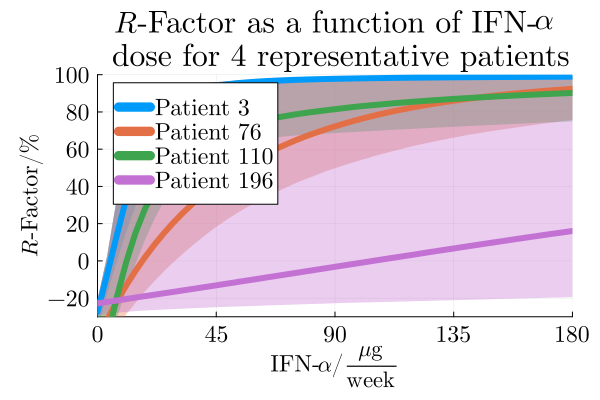

In [80]:
fig_R_factor = plot()
for i=1:length(p_vec)
    plot!(cI_lin*7,quantile.(eachrow(R_factor_mat[:,:,i]),0.025), fillrange = quantile.(eachrow(R_factor_mat[:,:,1]),0.975), 
            fillalpha = 0.35, colour = i, label = "", linealpha = 0)
end
for i=1:length(p_vec)
    plot!(cI_lin*7,median(R_factor_mat[:,:,i],dims=2), linewidth = 6, label = "Patient $(p_vec[i])", colour= i,
            xticks = (0:45:180, 0:45:180))
end
title!(L"$R$-Factor as a function of IFN-$\alpha$" *"\n dose for 4 representative patients")
xlabel!(L"IFN-$\alpha$/$\mathrm{\frac{\mu g}{week}}$")
ylabel!(L"$R$-Factor/%")
xlims!(0, 180)
ylims!(-30, 100)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, margin = 5mm,
legend = :right)

In [63]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

# Number of samples
n_samples = 10500

# Number of patients
P_train = length(unique_train_patients)

# Storage
all_param = Array{Float64, 2}(undef, P_train*(n_samples-500), 2)

# Extract mean parameter values
for i=1:P_train 
    # Set pID
    pID = unique_train_patients[i]
    
    # Extract data
    all_param[(i-1)*(n_samples-500)+1:i*(n_samples-500),1] = df_MCMC[:,"theta_$(pID)[1]"]
    all_param[(i-1)*(n_samples-500)+1:i*(n_samples-500),2] = df_MCMC[:,"theta_$(pID)[2]"]
end

In [82]:
# Generate samples
Q = 10^4
rand_ID = rand(1:size(all_param,1),Q)

# Bootstrap
# bootstrap_param = all_param[rand_ID,:]
bootstrap_param = all_param

# Define days for storing VAF
pDays = 0:30:2*365

# Define initVAF
initJAK = 0.38

# Define doses we want to investigate we want to investigate
cI_lin = (0:3:180)./7

# Storage
R_factor_mat_all = zeros(length(cI_lin),size(bootstrap_param,1))

# Calculate VAF in loop
@showprogress dt=1 desc="Calculating VAF and R-factor for all doses" for i=1:length(cI_lin)
    for j=1:size(bootstrap_param,1)
        # Define artificial patient with constant dose of IFN
        df_p = DataFrame(patientID = [-1,-1], days = [0,730], IFN = [cI_lin[i],cI_lin[i]], RUX = [NaN, NaN], JAK = [NaN, NaN], 
                         TRC = [NaN, NaN], WBC = [NaN, NaN])

        # Define parameters
        rho = bootstrap_param[j,:]

        # Calculate VAF using function
        VAF_mat_art, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)

        # Calculate R-factor and append
        R_factor_mat_all[i,j] = 100*(1 .- VAF_mat_art[end]./initJAK)
    end
end

Calculating VAF and R-factor for all doses 100%|█████████| Time: 5:45:37


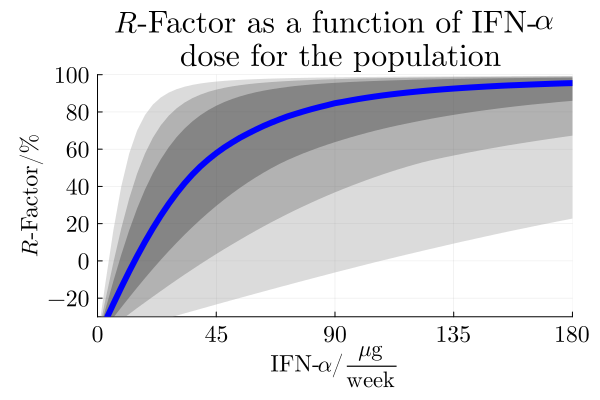

In [83]:
fig_R_factor_all = plot()
plot!(cI_lin*7,quantile.(eachrow(R_factor_mat_all),0.025), fillrange = quantile.(eachrow(R_factor_mat_all),0.975), 
            fillalpha = 0.35, colour = :grey60, label = "", linealpha = 0)
plot!(cI_lin*7,quantile.(eachrow(R_factor_mat_all),0.125), fillrange = quantile.(eachrow(R_factor_mat_all),0.875), 
            fillalpha = 0.35, colour = :grey40, label = "", linealpha = 0)
plot!(cI_lin*7,quantile.(eachrow(R_factor_mat_all),0.25), fillrange = quantile.(eachrow(R_factor_mat_all),0.75), 
            fillalpha = 0.35, colour = :grey20, label = "", linealpha = 0)
plot!(cI_lin*7,median(R_factor_mat_all,dims=2), linewidth = 6, label = "", colour= :blue1,
        xticks = (0:45:180, 0:45:180))
title!(L"$R$-Factor as a function of IFN-$\alpha$" *"\n dose for the population")
xlabel!(L"IFN-$\alpha$/$\mathrm{\frac{\mu g}{week}}$")
ylabel!(L"$R$-Factor/%")
xlims!(0, 180)
ylims!(-30, 100)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, margin = 5mm)

In [84]:
fig_dose_response = plot(fig_R_factor,fig_R_factor_all, layout = grid(1,2), size = (1400, 700), margin=5mm, leftmargin = 8mm, rightmargin = 8mm,
     bottommargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_dose_response,figpath*"dose_response.png")
savefig(fig_dose_response,figpath*"dose_response.pdf")
savefig(fig_dose_response,figpath*"dose_response.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\dose_response.svg"

## $R$-factor for all patients

In [85]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

# Number of patients
P_train = length(unique_train_patients)

# Storage
mean_param = Array{Float64, 2}(undef, P_train, 2)
median_param = Array{Float64, 2}(undef, P_train, 2)

# Extract mean parameter values
for i=1:P_train 
    # Set pID
    pID = unique_train_patients[i]
    
    # Extract data
    mean_param[i,1] = mean(df_MCMC[:,"theta_$(pID)[1]"])
    mean_param[i,2] = mean(df_MCMC[:,"theta_$(pID)[2]"])
    median_param[i,1] = median(df_MCMC[:,"theta_$(pID)[1]"])
    median_param[i,2] = median(df_MCMC[:,"theta_$(pID)[2]"])
end

# Define mean and median parameter vectors
mean_param_1_vec = mean_param[:,1]
mean_param_2_vec = mean_param[:,2]
median_param_1_vec = median_param[:,1]
median_param_2_vec = median_param[:,2]

56-element Vector{Float64}:
 0.4473950082299026
 0.5394832680500088
 0.18302065191174544
 0.5155467366649216
 0.25367389486988706
 0.1369484970196257
 0.05613717345534178
 0.1080500183460393
 0.19575648822915984
 0.036926144452718426
 0.08248378583880514
 0.2410066287034464
 0.10516117430994056
 ⋮
 0.48896149807266653
 0.33845046304305176
 0.7007042954756613
 0.41942309946850737
 0.1801886016576621
 0.22836015027210016
 0.27442096121824255
 0.10384191198195637
 0.030734239164529043
 0.2211730183123639
 0.19756584112641778
 0.18272117887380862

In [86]:
fig_R_factor = violin(collect(1:P_train)', R_factor', legend = false, xticks = (1:P_train, unique_train_patients))
scatter!(collect(1:P_train),median(R_factor[:,:],dims=2), markershape = :hline,color = :black, markersize = 4)
title!("Distribution of R-Factor for all Patients")
xlabel!("Patient ID")
ylabel!("R/"*L"\%")
ylims!(-50,100)
plot!(titlefont=15,xtickfontsize=6,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, 
        legend = :none, size = (1200, 500), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_R_factor,figpath*"R_factor.png")
savefig(fig_R_factor,figpath*"R_factor.pdf")
savefig(fig_R_factor,figpath*"R_factor.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\R_factor.svg"

In [87]:
# Parameter correlation - R-factor
fig_R_factor = scatter(median_param_1_vec,median_param_2_vec, zcolor=mean(R_factor[:,:],dims=2), 
                            markersize=6, label = "", color = :rainbow)
title!("R-Factor")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_R_factor,figpath*"R_factor.png")
savefig(fig_R_factor,figpath*"R_factor.pdf")
savefig(fig_R_factor,figpath*"R_factor.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\R_factor.svg"

## Population response to treatment schedules

In [64]:
# Define virtual patients with varying IFN doses
df_p_1 = DataFrame(patientID = [-1,-1], days = [0,730], IFN = [45/7,45/7], RUX = [NaN, NaN], 
                   JAK = [NaN, NaN], TRC = [NaN, NaN], WBC = [NaN, NaN])
df_p_2 = DataFrame(patientID = [-1,-1,-1], days = [0,365,730], IFN = [45/7,45/14,45/28], RUX = [NaN, NaN, NaN], 
                   JAK = [NaN, NaN, NaN], TRC = [NaN, NaN, NaN], WBC = [NaN, NaN, NaN])
df_p_3 = DataFrame(patientID = [-1,-1,-1], days = [0,365,730], IFN = [45/7,67.5/7,90/7], RUX = [NaN, NaN, NaN], 
                   JAK = [NaN, NaN, NaN], TRC = [NaN, NaN, NaN], WBC = [NaN, NaN, NaN])
df_p_4 = DataFrame(patientID = [-1,-1], days = [0,730], IFN = [90/7, 90/7], RUX = [NaN, NaN], 
                   JAK = [NaN, NaN], TRC = [NaN, NaN], WBC = [NaN, NaN])

# Define days for storing VAF
pDays = 0:30.4:7*365

# Choose seed
Random.seed!(42)

# Generate samples
Q = 10^4
rand_ID = rand(1:size(all_param,1),Q)

# Bootstrap
# bootstrap_param = all_param[rand_ID,:]
bootstrap_param = all_param

# Storage 
VAF_gen_1 = zeros(length(pDays), size(bootstrap_param,1))
VAF_gen_2 = zeros(length(pDays), size(bootstrap_param,1))
VAF_gen_3 = zeros(length(pDays), size(bootstrap_param,1))
VAF_gen_4 = zeros(length(pDays), size(bootstrap_param,1))

# Calculate VAF in loop
@showprogress dt=1 desc="Calculating VAF for all parameter samples" for i = 1:size(VAF_gen_1,2)
    # Set rho values
    rho = [bootstrap_param[i,1], bootstrap_param[i,2]]

    # Set initial JAK
    initJAK = 0.38

    # Calculate VAF using function
    VAF_gen_1[:,i], sol = model_calc_VAF(rho,df_p_1,effect,pDays,p,master_curve,initJAK)
    VAF_gen_2[:,i], sol = model_calc_VAF(rho,df_p_2,effect,pDays,p,master_curve,initJAK)
    VAF_gen_3[:,i], sol = model_calc_VAF(rho,df_p_3,effect,pDays,p,master_curve,initJAK)
    VAF_gen_4[:,i], sol = model_calc_VAF(rho,df_p_4,effect,pDays,p,master_curve,initJAK)
end

Calculating VAF for all parameter samples 100%|██████████| Time: 0:41:46


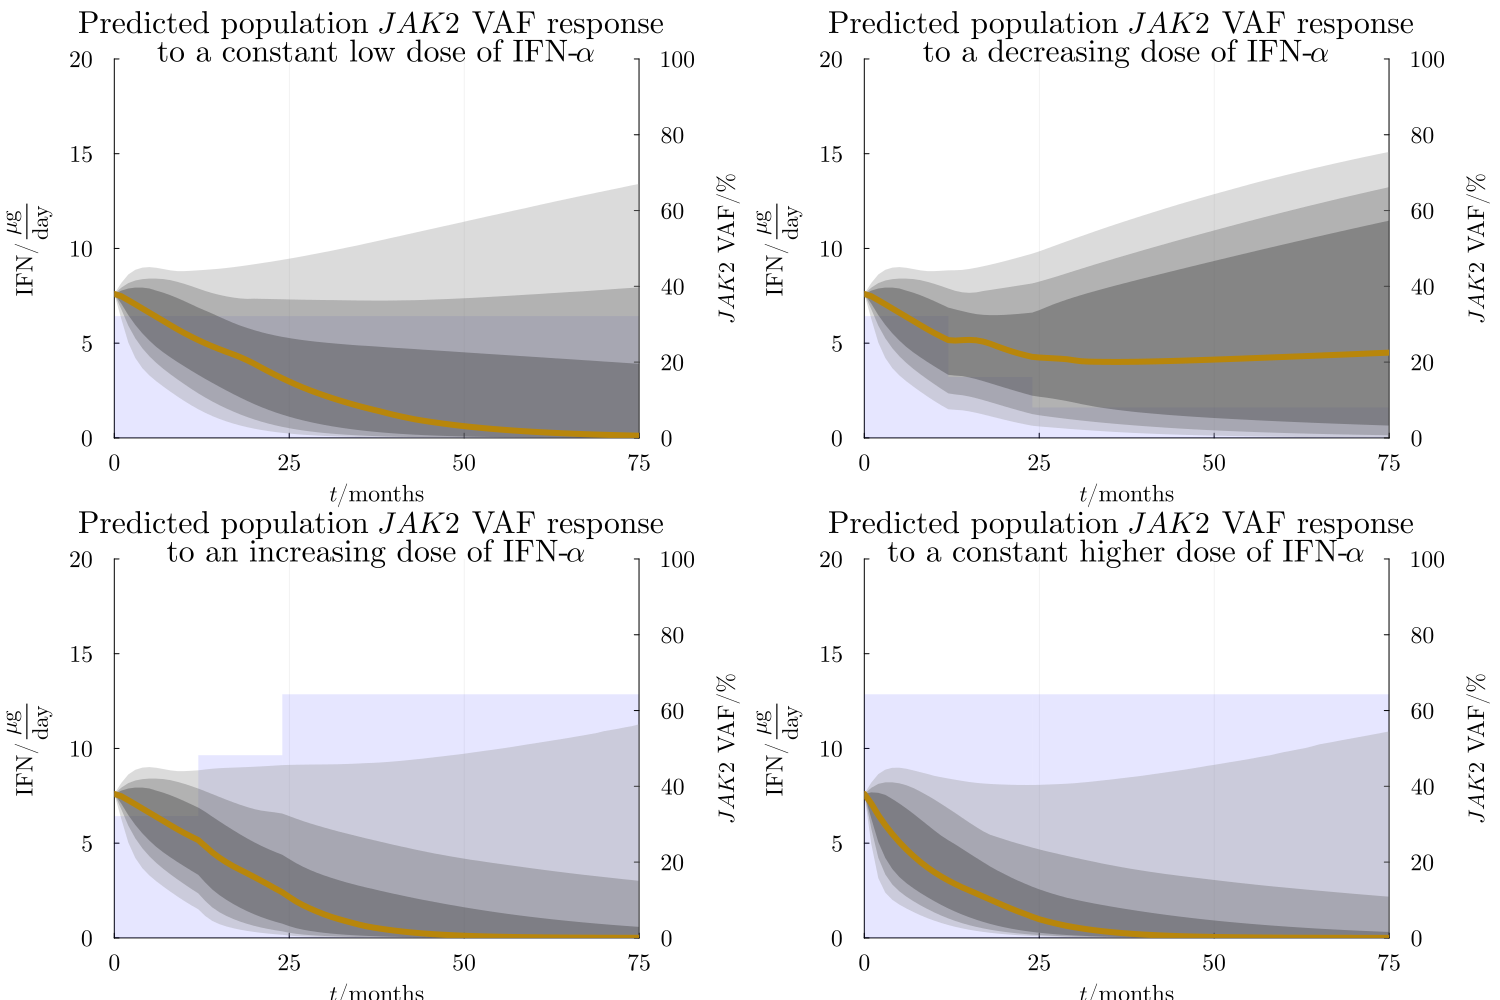

In [65]:
for i=1:4
    if i==1
        maxDays = maximum(df_p_1.days)
        figVAF = plot(df_p_1.days/30.4, zeros(size(df_p_1.days)), fillrange = df_p_1.IFN, line =:steppost, fillalpha = 0.1, 
                      linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p_1.IFN[end],df_p_1.IFN[end]], line =:steppost, fillalpha = 0.1, 
               linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        title!("Predicted population " * L"JAK2"*" VAF response \nto a constant low dose of "* L"IFN-$\alpha$")
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)
        p2 = twinx()
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_1), 0.025)*100, fillrange = quantile.(eachrow(VAF_gen_1), 0.975)*100, 
              fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_1), 0.125)*100, fillrange = quantile.(eachrow(VAF_gen_1), 0.875)*100, 
              fillalpha = 0.35, colour = :grey40, label = L"\textrm{90\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_1), 0.25)*100, fillrange = quantile.(eachrow(VAF_gen_1), 0.75)*100, 
              fillalpha = 0.35, colour = :grey20, label = L"\textrm{50\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, median(VAF_gen_1,dims=2)*100, linewidth = 6, label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    elseif i==2
        maxDays = maximum(df_p_2.days)
        figVAF = plot(df_p_2.days/30.4, zeros(size(df_p_2.days)), fillrange = df_p_2.IFN, line =:steppost, fillalpha = 0.1, 
                      linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p_2.IFN[end],df_p_2.IFN[end]], line =:steppost, fillalpha = 0.1, 
               linealpha = 0, linewidth = 6, label = "", colour= :blue1)
        title!("Predicted population " * L"JAK2"*" VAF response \nto a decreasing dose of "* L"IFN-$\alpha$")
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)
        p2 = twinx()
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_2), 0.025)*100, fillrange = quantile.(eachrow(VAF_gen_2), 0.975)*100, 
              fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_2), 0.125)*100, fillrange = quantile.(eachrow(VAF_gen_2), 0.875)*100, 
              fillalpha = 0.35, colour = :grey40, label = L"\textrm{90\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_2), 0.25)*100, fillrange = quantile.(eachrow(VAF_gen_2), 0.75)*100, 
              fillalpha = 0.35, colour = :grey20, label = L"\textrm{50\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, median(VAF_gen_2,dims=2)*100, linewidth = 6, label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    elseif i==3
        maxDays = maximum(df_p_3.days)
        figVAF = plot(df_p_3.days/30.4, zeros(size(df_p_3.days)), fillrange = df_p_3.IFN, line =:steppost, fillalpha = 0.1, 
                      linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p_3.IFN[end],df_p_3.IFN[end]], line =:steppost, fillalpha = 0.1, 
               linealpha = 0, linewidth = 6, label = "", colour= :blue1)
        title!("Predicted population " * L"JAK2"*" VAF response \nto an increasing dose of "* L"IFN-$\alpha$")
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)
        p2 = twinx()
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_3), 0.025)*100, fillrange = quantile.(eachrow(VAF_gen_3), 0.975)*100, 
              fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_3), 0.125)*100, fillrange = quantile.(eachrow(VAF_gen_3), 0.875)*100, 
              fillalpha = 0.35, colour = :grey40, label = L"\textrm{90\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_3), 0.25)*100, fillrange = quantile.(eachrow(VAF_gen_3), 0.75)*100, 
              fillalpha = 0.35, colour = :grey20, label = L"\textrm{50\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, median(VAF_gen_3,dims=2)*100, linewidth = 6, label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    elseif i==4
        maxDays = maximum(df_p_4.days)
        figVAF = plot(df_p_4.days/30.4, zeros(size(df_p_4.days)), fillrange = df_p_4.IFN, line =:steppost, fillalpha = 0.1, 
                      linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        plot!([maxDays/30.4,75], zeros(2), fillrange = [df_p_4.IFN[end],df_p_4.IFN[end]], line =:steppost, fillalpha = 0.1, 
               linealpha = 0, linewidth = 3, label = "", colour= :blue1)
        title!("Predicted population " * L"JAK2"*" VAF response \nto a constant higher dose of "* L"IFN-$\alpha$")
        xlabel!(L"t"*"/months")
        ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
        xlims!(0, 75)
        ylims!(0, 20)
        p2 = twinx()
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_4), 0.025)*100, fillrange = quantile.(eachrow(VAF_gen_4), 0.975)*100, 
              fillalpha = 0.35, colour = :grey60, label = L"\textrm{95\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_4), 0.125)*100, fillrange = quantile.(eachrow(VAF_gen_4), 0.875)*100, 
              fillalpha = 0.35, colour = :grey40, label = L"\textrm{90\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, quantile.(eachrow(VAF_gen_4), 0.25)*100, fillrange = quantile.(eachrow(VAF_gen_4), 0.75)*100, 
              fillalpha = 0.35, colour = :grey20, label = L"\textrm{50\%\ Credibility\ Interval}", linealpha = 0)
        plot!(p2, pDays/30.4, median(VAF_gen_4,dims=2)*100, linewidth = 6, label = L"JAK2"*" VAF - Median", colour = :darkgoldenrod)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 75)
        ylims!(p2, 0, 100)
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend = :none)
    end

    if i==1
        fig1 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==2
        fig2 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==3
        fig3 = plot(figVAF, size = (700, 500), margin=5mm)
    elseif i==4
        fig4 = plot(figVAF, size = (700, 500), margin=5mm)
    end
end

# Plot all 4 figures
figCombined = plot(fig1, fig2, fig3, fig4, layout=grid(2,2), size = (1500, 1000), margin = 5mm, leftmargin = 8mm, 
                   rightmargin = 8mm)

# Save figure
# figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
# savefig(figCombined,figpath*"VAF_gen.png")
# savefig(figCombined,figpath*"VAF_gen.pdf")
# savefig(figCombined,figpath*"VAF_gen.svg")

In [90]:
print([quantile(VAF_gen_1[2*12+1,:],0.025), median(VAF_gen_1[2*12+1,:]), quantile(VAF_gen_1[2*12+1,:],0.975)])
print([quantile(VAF_gen_2[2*12+1,:],0.025), median(VAF_gen_2[2*12+1,:]), quantile(VAF_gen_2[2*12+1,:],0.975)])
print([quantile(VAF_gen_3[2*12+1,:],0.025), median(VAF_gen_3[2*12+1,:]), quantile(VAF_gen_3[2*12+1,:],0.975)])
print([quantile(VAF_gen_4[2*12+1,:],0.025), median(VAF_gen_4[2*12+1,:]), quantile(VAF_gen_4[2*12+1,:],0.975)])

[0.013346157592721616, 0.15738964013237583, 0.46990106126057224][0.03221260467321374, 0.21386121016589194, 0.48626621475118087][0.008256211896658436, 0.1204507007377919, 0.45591619613309275][0.005145896177946773, 0.05586383774232419, 0.4035955137389266]

In [91]:
[sum(VAF_gen_1[2*12+1,:].<0.33)/size(VAF_gen_1[2*12+1,:],1), 
 sum(VAF_gen_2[2*12+1,:].<0.33)/size(VAF_gen_1[2*12+1,:],1), 
 sum(VAF_gen_3[2*12+1,:].<0.33)/size(VAF_gen_1[2*12+1,:],1),
 sum(VAF_gen_4[2*12+1,:].<0.33)/size(VAF_gen_1[2*12+1,:],1)]

4-element Vector{Float64}:
 0.8370732142857142
 0.7482982142857143
 0.8766660714285714
 0.9451303571428571

## Measured vs. predicted VAF

In [92]:
# Plot real vs. predicted VAF
plot_real_predict = scatter(real_VAF*100,predicted_VAF*100, markercolor=:red, markersize=4, markerstrokewidth=0.25, label = "")
plot!([0,100],[0,100], linewidth = 3, colour = :black, label="")
title!(L"Measured vs. Predicted $JAK2$ VAF")
xlabel!(L"Measured $JAK2$ VAF/%")
ylabel!(L"Predicted $JAK2$ VAF/%")
xlims!(0,100)
ylims!(0,100)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
fig_real_predict = plot(plot_real_predict, size = (1000, 700), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_real_predict,figpath*"Hierarchical_real_predict_$(effect).png")
savefig(fig_real_predict,figpath*"Hierarchical_real_predict_$(effect).pdf")
savefig(fig_real_predict,figpath*"Hierarchical_real_predict_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Hierarchical_real_predict_py0dy1.svg"

In [93]:
# Plot predicted VAF vs. residuals
plot_predict_residual = scatter(predicted_VAF*100,(real_VAF-predicted_VAF)*100, markercolor=:red, markersize=4, markerstrokewidth=0.25, label = "")
title!(L"Residual vs. Inferred $JAK2$ VAF")
xlabel!(L"Inferred $JAK2$ VAF/%")
ylabel!(L"Residual $JAK2$ VAF/%")
xlims!(0,100)
ylims!(-60,60)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)
fig_predict_residual = plot(plot_predict_residual, size = (1000, 700), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_predict_residual,figpath*"Hierarchical_predict_residual_$(effect).png")
savefig(fig_predict_residual,figpath*"Hierarchical_predict_residual_$(effect).pdf")
savefig(fig_predict_residual,figpath*"Hierarchical_predict_residual_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Hierarchical_predict_residual_py0dy1.svg"

## Parameter correlation and clustering

In [51]:
# Setup dataframe
df_P = DataFrame

# Load patient information
path = "M:/data_cancer/DALIAH/Trine_DALIAH_5y/DALIAH_5y_patient_information - Export for Julia.csv"
df_P = CSV.read(path, df_P)

# Change data types
df_P[!,:male] = convert.(Bool,df_P[:,:male])
df_P[!,:PV] = convert.(Bool,df_P[:,:PV])
df_P[!,:ET] = convert.(Bool,df_P[:,:ET])
df_P[!,:MF] = convert.(Bool,df_P[:,:MF])
df_P[!,:Pegasys] = convert.(Bool,df_P[:,:Pegasys])
df_P[!,:PegIntron] = convert.(Bool,df_P[:,:PegIntron])
df_P[!,:BothIFN] = convert.(Bool,df_P[:,:BothIFN])

# Remove test patients
for i=1:length(test_patients)
    tempID = test_patients[i]
    deleteat!(df_P, df_P.patientID .== tempID)
end

df_P

Row,patientID,male,age,PV,ET,MF,Phlebotomies,initVAF,Pegasys,PegIntron,BothIFN
,Int64,Bool,Int64,Bool,Bool,Bool,Int64,Float64,Bool,Bool,Bool
1,2,true,52,true,false,false,12,0.49,false,true,false
2,3,true,46,true,false,false,4,0.54,true,false,false
3,4,false,45,true,false,false,1,0.31,true,false,false
4,11,false,51,true,false,false,6,0.11,true,false,false
5,14,true,69,false,false,true,0,0.59,false,true,false
6,20,false,64,true,false,false,15,0.5,true,false,false
7,22,true,39,true,false,false,8,0.44,false,false,true
8,34,true,43,false,true,false,5,0.33,true,false,false
9,35,true,77,true,false,false,3,0.61,false,true,false


In [95]:
# Parameter correlation - age
plot_param_age = scatter(median_param_1_vec,median_param_2_vec, zcolor=df_P.age, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "", color = :rainbow)
title!("Age")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - sex
plot_param_sex = scatter(median_param_1_vec[df_P.male],median_param_2_vec[df_P.male], markercolor=:lightskyblue1, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[(!).(df_P.male)],median_param_2_vec[(!).(df_P.male)], markercolor=:hotpink, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
title!("Sex")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - initVAF
plot_param_initVAF = scatter(median_param_1_vec,median_param_2_vec, zcolor=df_P.initVAF, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "", color = :rainbow)
title!(L"$JAK2$ VAF at Baseline")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - diagnosis
plot_param_diagnosis = scatter(median_param_1_vec[df_P.PV],median_param_2_vec[df_P.PV], markercolor=:red, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.ET],median_param_2_vec[df_P.ET], markercolor=:green, mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.MF],median_param_2_vec[df_P.MF], markercolor=:blue, mamarkersize=6, markerstrokewidth=0.25, label = "")
title!("Diagnosis")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - diagnosis
plot_param_diagnosis = scatter(median_param_1_vec[df_P.PV],median_param_2_vec[df_P.PV], markercolor=:red, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.ET],median_param_2_vec[df_P.ET], markercolor=:green, mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.MF],median_param_2_vec[df_P.MF], markercolor=:blue, mamarkersize=6, markerstrokewidth=0.25, label = "")
title!("Diagnosis")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - R-factor
plot_R_factor = scatter(median_param_1_vec,median_param_2_vec, zcolor=median(R_factor[:,:],dims=2), 
                            mamarkersize=6, markerstrokewidth=0.25, label = "", color = :rainbow)
title!("R-Factor")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Parameter correlation - brand
plot_brand = scatter(median_param_1_vec[df_P.Pegasys],median_param_2_vec[df_P.Pegasys], markercolor=:blue, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.PegIntron],median_param_2_vec[df_P.PegIntron], markercolor=:red, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
scatter!(median_param_1_vec[df_P.BothIFN],median_param_2_vec[df_P.BothIFN], markercolor=:darkorchid2, 
                            mamarkersize=6, markerstrokewidth=0.25, label = "")
title!(L"Brand of IFN-$\alpha$")
xlabel!(L"\rho/\mathrm{(\frac{\mu g}{day}})^{-1}")
ylabel!(L"\delta/\mathrm{(\frac{\mu g}{day}})^{-1}")
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :none)

# Collect plots
l = @layout [a a; a a; a a;]
fig_param_correlation = plot(plot_param_age, plot_param_sex, plot_param_initVAF, plot_param_diagnosis, plot_R_factor, 
                             plot_brand, layout = l, size = (1000, 1000), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_param_correlation,figpath*"Parameter_correlation_grouping_$(effect).png")
savefig(fig_param_correlation,figpath*"Parameter_correlation_grouping_$(effect).pdf")
savefig(fig_param_correlation,figpath*"Parameter_correlation_grouping_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\Parameter_correlation_grouping_py0dy1.svg"

## Boxplot as function of diagnosis

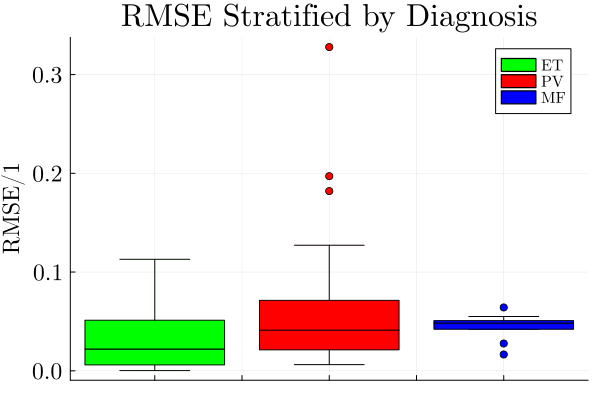

In [52]:
fig_boxpplot_RMSE = boxplot(mean_RMSE_vec[df_P.ET], color = :green1, label="ET")
boxplot!(mean_RMSE_vec[df_P.PV], color = :red1, label="PV")
boxplot!(mean_RMSE_vec[df_P.MF], color = :blue1, label="MF")
title!("RMSE Stratified by Diagnosis")
ylabel!("RMSE/1")
xticks = (1)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
        legend = :topright, xformatter=_->"")

# Save figure
# figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
# savefig(fig_boxpplot_RMSE,figpath*"boxplot_RMSE_$(effect).png")
# savefig(fig_boxpplot_RMSE,figpath*"boxplot_RMSE_$(effect).pdf")
# savefig(fig_boxpplot_RMSE,figpath*"boxplot_RMSE_$(effect).svg")

In [53]:
ExactMannWhitneyUTest(mean_RMSE_vec[df_P.ET], mean_RMSE_vec[df_P.PV])

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0190398

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0768

Details:
    number of observations in each group: [15, 32]
    Mann-Whitney-U statistic:             162.0
    rank sums:                            [282.0, 846.0]
    adjustment for ties:                  0.0


In [54]:
ExactMannWhitneyUTest(mean_RMSE_vec[df_P.ET], mean_RMSE_vec[df_P.MF])

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0261918

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1383

Details:
    number of observations in each group: [15, 9]
    Mann-Whitney-U statistic:             42.0
    rank sums:                            [200.0, 100.0]
    adjustment for ties:                  0.0


In [55]:
ExactMannWhitneyUTest(mean_RMSE_vec[df_P.PV], mean_RMSE_vec[df_P.MF])

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.00715203

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6311

Details:
    number of observations in each group: [32, 9]
    Mann-Whitney-U statistic:             128.0
    rank sums:                            [641.0, 220.0]
    adjustment for ties:                  0.0


## Compare with ruxolitinib work

In [97]:
# Type in results from RUXO work
RUX = [35*ones(18,); 20*ones(6,)]
rho = [0.248; 0.122; 0.11; 0.0994; 0.108; 0.118; 0.155; 0.102; 0.109; 0.112; 0.12; 0.131; 0.161; 0.116; 0.813; 0.143; 
       1.05; 0.0882; 0.379; 0.198; 0.176; 0.00826; 0.483; 0.0268]

# Collect in dataframe
df_RUX = DataFrame(RUX=RUX,rho=rho)

# Calculate dy1-value during treatment
df_RUX.dy1 = @. (1+df_RUX.rho*df_RUX.RUX)*p.dy1

# Calculate percentage increase
mean(df_RUX.dy1./p.dy1)

7.754883333333333

In [98]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

# Number of patients
P_train = length(unique_train_patients)

# Find patients who had reduction in VAF of at least 20%
reduc_20 = falses(P,)

for i=1:P_train
    # Extract relevant data
    pID = unique_train_patients[i]
    df_p = df_D_train[df_D_train.patientID .== pID, :]
    VAF = df_p.JAK[.!isnan.(df_p.JAK) .* (df_p.days.<=2*365)]
    
    # Calculate reductions in VAF
    diff_vec = VAF[1].-VAF
    
    # Check if any reduction is greater than 0.2
    if sum(diff_vec .> 0.2)>0
        reduc_20[i] = true
    end
end
mean(reduc_20)

0.2

In [99]:
# Extract parameters for delta
temp = mean_param[:,2]

# Calculate dy1-value during treatment only for the ones experiencing large reductions in VAF
IFN_dy1_reduc_20 = @. (1+temp[reduc_20]*45/7)*p.dy1

# Calculate percentage increase
mean(IFN_dy1_reduc_20)/p.dy1

LoadError: BoundsError: attempt to access 56-element Vector{Float64} at index [70-element BitVector]

## Compare to results by Pedersen et al.

In [100]:
# Test mean_Rhat_vec
mean_Rhat_vec

56-element Vector{Float64}:
   0.9839229269937666
   0.9595433749770147
   0.6971606972003611
   0.8345094412567345
 -Inf
   0.888903616377472
  -0.2908223853061662
  -0.7641515809477639
   1.88027227470003
   0.6902992084912788
  44.975248057973616
   0.7677917607760816
  -4.632332113135681
   ⋮
   0.3578327107934669
  -0.9426843446704796
   0.9822048953480884
   0.9588324777275286
  -2.856093178083238
   0.006155933172724559
  -8.395660057951572
   0.9947838120297527
   0.1418418099151667
 -Inf
 -Inf
   7.150012648335441

In [101]:
# Input numbers from Rasmus
R_hat_Rasmus = [0.997; 0.928; 0.0168; -0.0507; 0.524; -0.27; 0.653; 0.828; 0.902; 0.867; -0.405; 0.389; 0.882; 0.786; 0.758;
                -1; -0.904; -0.31; 0.874; -2.26; NaN; 0.93; 0.41; 0.987; -0.128; -3.65; -2.82; -3.21; -2.88; 0.86; 0.241; 0.317;
                0.341; 0.901; -4.32; 0.94; -1.28; 0.795; 0.0392; 0.288; -0.422; -0.982; -2.57; -0.494; -1.22; 0.985; 0.848; 
                0.728; -0.0476; 0.669; -5.3; -3.65; 0.936; 0.877; -2.35; -0.109; -1; 0.993; 0.475; -1.59; -1.74; -0.317; NaN]

63-element Vector{Float64}:
   0.997
   0.928
   0.0168
  -0.0507
   0.524
  -0.27
   0.653
   0.828
   0.902
   0.867
  -0.405
   0.389
   0.882
   ⋮
  -3.65
   0.936
   0.877
  -2.35
  -0.109
  -1.0
   0.993
   0.475
  -1.59
  -1.74
  -0.317
 NaN

In [102]:
mean(R_hat_Rasmus[.!isnan.(R_hat_Rasmus)])

-0.36580819672131154

In [103]:
mean(mean_Rhat_vec[n_data_vec.>4])

-0.9296776615196827

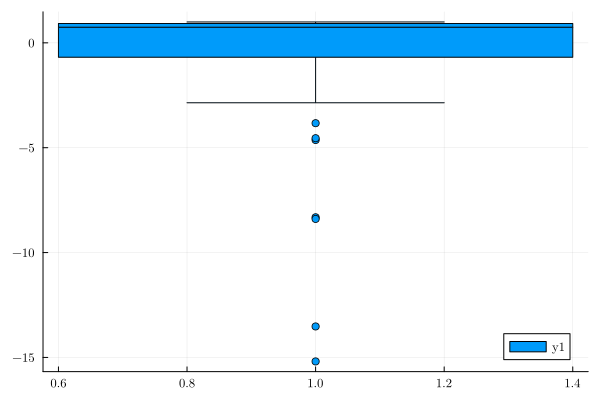

In [104]:
boxplot(mean_Rhat_vec[n_data_vec.>4])

In [105]:
sum(R_hat_Rasmus[.!isnan.(R_hat_Rasmus)].>=0.5)/61

0.39344262295081966

In [106]:
sum(mean_Rhat_vec[n_data_vec.>4].>=0.5)/sum(n_data_vec.>4)

0.5869565217391305

In [107]:
mean_Rhat_vec[1:20]

20-element Vector{Float64}:
   0.9839229269937666
   0.9595433749770147
   0.6971606972003611
   0.8345094412567345
 -Inf
   0.888903616377472
  -0.2908223853061662
  -0.7641515809477639
   1.88027227470003
   0.6902992084912788
  44.975248057973616
   0.7677917607760816
  -4.632332113135681
   1.0532606882024358
   0.9617099217483986
  -4.546505968387023
   0.8198180138190185
   0.9234627156976674
   1.7382694579209403
   0.8503523954045314

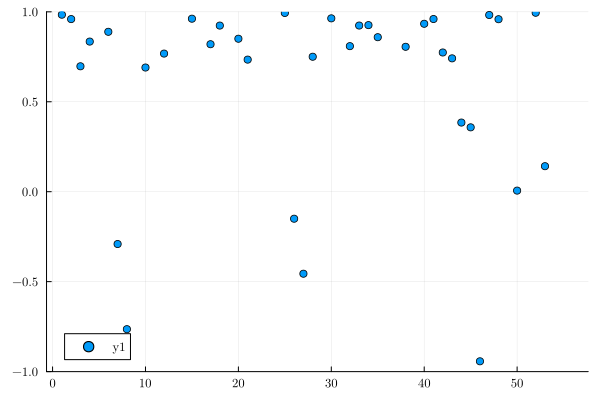

In [108]:
scatter(mean_Rhat_vec)
ylims!(-1,1)

## Violin plots for parameters

In [109]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

# Extract rho_p_y_0
df_rho_p_y_0 = df_MCMC[:,7:4:end-1]
df_rho_p_y_0 = Matrix(df_rho_p_y_0)

fig_violin = violin(collect(1:P_train)', df_rho_p_y_0, legend = false, xticks = (1:P_train, unique_train_patients))
scatter!(collect(1:P_train)',median(df_rho_p_y_0,dims=1), markershape = :hline,color = :black, markersize = 4)
title!("\nDistribution of "*L"\rho "*" for all patients")
xlabel!("Patient ID")
ylabel!(L"\rho/\textrm{(\mu g/day)}^{-1}")
ylims!(0.0,1)
plot!(titlefont=15,xtickfontsize=6,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, 
        legend = :none, size = (1200, 500), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_violin,figpath*"violin_py0.png")
savefig(fig_violin,figpath*"violin_py0.pdf")
savefig(fig_violin,figpath*"violin_py0.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\violin_py0.svg"

In [110]:
# Unique patients
unique_train_patients = unique(df_D_train.patientID)

# Extract rho_d_y_1
df_rho_d_y_1 = df_MCMC[:,8:4:end-1]
df_rho_d_y_1 = Matrix(df_rho_d_y_1)

fig_violin = violin(collect(1:P_train)', df_rho_d_y_1, legend = false, xticks = (1:P_train, unique_train_patients))
scatter!(collect(1:P_train)',median(df_rho_d_y_1,dims=1), markershape = :hline,color = :black, markersize = 4)
title!("\nDistribution of "*L"\delta "*" for all patients")
xlabel!("Patient ID")
ylabel!(L"\delta/\textrm{(\mu g/day)}^{-1}")
ylims!(0.0,1)
plot!(titlefont=15,xtickfontsize=6,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, 
        legend = :none, size = (1200, 500), margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Hierarchical/Gibbs/Train_test/"
savefig(fig_violin,figpath*"violin_dy1.png")
savefig(fig_violin,figpath*"violin_dy1.pdf")
savefig(fig_violin,figpath*"violin_dy1.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Hierarchical\\Gibbs\\Train_test\\violin_dy1.svg"

## Plots for illustrating model behaviour

In [111]:
# Define variables for virtual patients 
days1 = 0:365:70*365
days2 = 0:30:2*365
IFN1 = 45/7*ones(size(days1))
IFN2 = 45/7*ones(size(days2))
patientID1 = -1*ones(size(days1))
patientID2 = -1*ones(size(days2))
RUX1 = NaN*ones(size(days1))
RUX2 = NaN*ones(size(days2))
JAK1 = NaN*ones(size(days1))
JAK2 = NaN*ones(size(days2))
TRC1 = NaN*ones(size(days1))
TRC2 = NaN*ones(size(days2))
WBC1 = NaN*ones(size(days1))
WBC2 = NaN*ones(size(days2))

# Define virtual patient with constant dose of IFN
df_p_1 = DataFrame(patientID = patientID1, days = days1, IFN = IFN1, RUX = RUX1, JAK = JAK1, TRC = TRC1, WBC = WBC1)
df_p_2 = DataFrame(patientID = patientID2, days = days2, IFN = IFN2, RUX = RUX2, JAK = JAK2, TRC = TRC2, WBC = WBC2)

# Define rho value
rho_vec = [[0.0,0.0], [0.5,0.0], [0.0,0.5], [0.5,0.5]]
rho_vec = [[0.0,0.0], [1.0,0.0], [0.0,1.0], [1.0,1.0]]

# Choose effect
effect = "py0dy1"

# Create empty plots
fig1 = plot()
fig2 = plot()
fig3 = plot()
fig4 = plot()

# Storage
init1 = zeros(8)
init2 = zeros(8)

# Calculate model output for all virtual patients
@showprogress dt=1 desc="Plotting and saving results for 4 virtual patients..." for i=1:4
    # Choose patient and initJAK
    if i==1
        df_p = df_p_1
        initJAK = 0
    else
        df_p = df_p_2
        initJAK = 0.38
    end
    
    # Extract rho
    rho = rho_vec[i]
    
    # Extract relevant variables
    pDays = df_p.days
    
    # Calculate VAF using function
    VAF_mat, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)

    # Save all variables
    p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
    a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
    
    if i==1
        init1 = [p_curve.x0[1], p_curve.x1[1], p_curve.x2[1], p_curve.y0[1], p_curve.y1[1], p_curve.y2[1], p_curve.a[1],
                 p_curve.s[1]]
    else
        init2 = [p_curve.x0[1], p_curve.x1[1], p_curve.x2[1], p_curve.y0[1], p_curve.y1[1], p_curve.y2[1], p_curve.a[1],
                 p_curve.s[1]]
    end
    
    # Plot 
    figS = plot(p_curve.t/365, p_curve.x0, linewidth = 3,colour=:green1)
    plot!(p_curve.t/365, p_curve.y0, linewidth = 3,colour=:red1)
    plot!(p_curve.t/365, p_curve.x0+p_curve.y0, linewidth = 3,colour=:black,linestyle=:dash)
    title!("Stem Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,2*10^5)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figP = plot(p_curve.t/365, p_curve.x1, linewidth = 3,colour=:green1)
    plot!(p_curve.t/365, p_curve.y1, linewidth = 3,colour=:red1)
    plot!(p_curve.t/365, p_curve.x1+p_curve.y1, linewidth = 3,colour=:black,linestyle=:dash)
    title!("Progenitor and\n Precursor Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,10*10^6)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    figM = plot(p_curve.t/365, p_curve.x2, linewidth = 3, label="Healthy cells",colour=:green1)
    plot!(p_curve.t/365, p_curve.y2, linewidth = 3, label="Malignant cells",colour=:red1)
    plot!(p_curve.t/365, p_curve.x2+p_curve.y2, linewidth = 3, label="Sum of healthy\n and malignant cells",colour=:black,linestyle=:dash)
    title!("Mature Cells")
    xlabel!(L"t"*"/years")
    ylabel!("Cells"*L"/1")
    ylims!(0,30*10^11)
    if i==4
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10)
    else
        plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, legend=:none)
    end
    figVAF = plot(p_curve.t/365, p_curve.y2./(p_curve.x2+p_curve.y2)*100, linewidth = 3, label = L"JAK2", colour= :darkgoldenrod1)
    title!(L"JAK2"*" VAF")
    xlabel!(L"t"*"/years")
    ylabel!(L"JAK2"*" VAF/%")
    ylims!(0,100)
    plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=15, legend=:none)
    
    # Assign to plot
    if i==1
        fig1 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==2
        fig2 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==3
        fig3 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    elseif i==4
        fig4 = plot(figS, figP, figM, figVAF, layout=grid(2, 2), link =:x, size = (800, 800), margin=5mm)
    end
end

# Plot all 4 figures
figCombined = plot(fig1, fig2, fig3, fig4, layout=grid(2,2), size = (1600, 1600))

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figCombined,figpath*"gen_sim_$(effect).png")
savefig(figCombined,figpath*"gen_sim_$(effect).pdf")
savefig(figCombined,figpath*"gen_sim_$(effect).svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\gen_sim_py0dy1.svg"

In [112]:
# Define variables for virtual patients 
days = 0:30:2*365
IFN = 45/7*ones(size(days))
patientID = -1*ones(size(days))
RUX = NaN*ones(size(days))
JAK = NaN*ones(size(days))
TRC = NaN*ones(size(days))
WBC = NaN*ones(size(days))

# Define virtual patient with constant dose of IFN
df_p = DataFrame(patientID = patientID, days = days, IFN = IFN, RUX = RUX, JAK = JAK, TRC = TRC, WBC = WBC)

# Choose values of rho and delta
delta_vec = [0.5, 0.25, 0.1, 0.05]
rho_vec = [0.05, 0.1, 0.25, 0.5]

# Choose days for solution
pDays = 0:30:2*365

# Choose effect
effect = "py0dy1"

# Setup for grid plot
grid_plot = Any[]
grid_plot_2 = Any[]

# Counter
counter = 0

# Solve in loop
for i=1:length(delta_vec)
    for j=1:length(rho_vec)
        # Update counter 
        counter = counter + 1

        # Choose values of rho and delta
        rho = [rho_vec[j], delta_vec[i]]

        # Choose initial VAF for simulation
        initJAK= 38/100
        
        # Calculate VAF using function
        VAF, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)

        # Save all variables
        p_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
        a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))
       #  @show maximum(VAF)
        # Plot
        figVAF = plot([0, 2.5*365]/365, zeros(2), fillrange = [45/7; 45/7], fillalpha = 0.1, 
                        linealpha = 0, line =:steppost, linewidth = 3, label = "", colour= :blue1)
        xlims!(0, 2)
        ylims!(0, 20)
        title!("\n" * L"\rho"
           *"=$(round(rho_vec[j]; sigdigits=3)), " * L"\delta"*"=$(round(delta_vec[i]; sigdigits=3))")
        xlabel!(L"t"*"/years")
        ylabel!(L"IFN-$\alpha$/"*L"\mathrm{\frac{\mu g}{day}}")
        p2 = twinx()
        plot!(p2, p_curve.t/365, VAF*100, linewidth = 3, label = L"JAK2", colour= :darkgoldenrod1)
        ylabel!(p2, L"JAK2"*" VAF/%")
        xlims!(p2, 0, 2)
        ylims!(p2, 0, 100)
        
        # Plot
        figMatCells = plot([0, 2.5*365]/365, zeros(2), fillrange = [45/7; 45/7], fillalpha = 0.1, 
                        linealpha = 0, line =:steppost, linewidth = 3, label = "", colour= :blue1)
        xlims!(0, 2)
        ylims!(0, 20)
        title!("\n" * L"\rho"
           *"=$(round(rho_vec[j]; sigdigits=3)), " * L"\delta"*"=$(round(delta_vec[i]; sigdigits=3))")
        xlabel!(L"t"*"/years")
        ylabel!(L"IFN-$\alpha$/"*L"\mathrm{\frac{\mu g}{day}}")
        p2 = twinx()
        plot!(p2, p_curve.t/365, p_curve.x2, linewidth = 3, label="",colour=:green1)
        plot!(p2, p_curve.t/365, p_curve.y2, linewidth = 3, label="",colour=:red1)
        plot!(p2, p_curve.t/365, p_curve.x2+p_curve.y2, linewidth = 3, label="",colour=:black,linestyle=:dash)
        ylabel!(p2, "Cells"*L"/1")
        xlims!(p2, 0, 2)
        ylims!(p2, 0, 30*10^11)

        # Add to plot
        push!(grid_plot, figVAF)
        push!(grid_plot_2, figMatCells)
    end
end

In [113]:
# Plot all
figAll = plot(grid_plot..., layout= (4,4), titlefont=20, xtickfontsize=15, ytickfontsize=15, xguidefontsize=15, yguidefontsize=15, 
    legendfontsize=15, legend=:none, size = (2000, 2000), margin=5mm, leftmargin = 8mm, rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figAll,figpath*"vary_response.png")
savefig(figAll,figpath*"vary_response.pdf")
savefig(figAll,figpath*"vary_response.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\vary_response.svg"

In [114]:
# Plot all
figAllCells = plot(grid_plot_2..., layout= (4,4), titlefont=20, xtickfontsize=15, ytickfontsize=15, xguidefontsize=15, yguidefontsize=15, 
    legendfontsize=15, legend=:none, size = (2000, 2000), margin=5mm, leftmargin = 8mm, rightmargin = 8mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/"
savefig(figAllCells,figpath*"vary_response_cells.png")
savefig(figAllCells,figpath*"vary_response_cells.pdf")
savefig(figAllCells,figpath*"vary_response_cells.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\vary_response_cells.svg"